In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

# Read in data:
# Cloud_Sections
cloud_sections = pd.read_csv('Cleaned/CLOUD_SECTIONS_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Designed_Pipe_Center
designed_centers = pd.read_csv('Cleaned/DESIGNED_Pipe_Centers_Cleaned.csv', delimiter = ',', encoding = 'latin1')

# Planes_Local_Global_Cleaned
p_info = pd.read_csv('Cleaned/Planes_Local_Global_Cleaned.csv', delimiter = ',', encoding = 'latin1')

In [2]:
# A List of sections, where each section is a list of tuples, and each tuple is the XY coordinates of a point on the point cloud
TuplePairsBySection = [] 

# A list of the Designed Center points and radius, each object in the list is a panda dataframe where there are as many rows as pipes
CenterList = [] 

# For n in the number of distinct sections
for n in range(cloud_sections.Section.nunique()): 
    
    # Grabs all dataframe rows in each distinct section
    grab = cloud_sections[cloud_sections['Section'] == 'Section-{' + str(n) + '}'] 
    
    # Adds the individual X and Y points in each point cloud pair for the nth section
    TuplePairsBySection.append(list(zip(grab.X, grab.Y))) 
    
    # Adds the dataframe rows in each distinct section
    CenterList.append(designed_centers[designed_centers['Section'] == 'Section-{' + str(n) + '}']) 

In [3]:
# Arbitrary radius multiplier
N = 1.4

# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesFirstNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsFirstNoiseTestBySection = [] 

count = 0 
for section in TuplePairsBySection:
    D, E, F = [], [], []
    
    # Intialize the radius for both pipes
    r1, r2 = CenterList[count].iloc[0,4], CenterList[count].iloc[1,4] 
    
    # Intialize the center XY coordinate tuple for both pipes
    c1, c2 = tuple(CenterList[count].iloc[0,1:3]), tuple(CenterList[count].iloc[1,1:3]) 
    
    for point in section: 
        
        # Test first pipe
        if math.dist(c1, point) < (r1 * N): 
            D.append(point)
            
        # Test second pipe
        elif math.dist(c2, point) < (r2 * N): 
            E.append(point)
        else:
            F.append(point)
            
    PassesFirstNoiseTestBySection.append(D)
    PassesFirstNoiseTestBySection.append(E)
    FailsFirstNoiseTestBySection.append(F)
    count += 1

In [4]:
# Arbitrary IQR multiplier
M = 1.3

def findOutVals(rlist):
    P, F = {}, {}
    P_index = []
    sortedList = sorted(rlist)
    L = len(rlist)
    Q1 = np.median(sortedList[:(L//2 + 2)]) 
    Q3 = np.median(sortedList[(L//2 + 1):])
    IQR = Q3 - Q1
    L_out = Q1 - IQR*M
    R_out = Q3 + IQR*M
    count = 0
    for n in rlist:
        if (n > L_out) and (n < R_out):
            P[count] = n
        count += 1
    for a in P:
        P_index.append(a)
    return P_index

In [5]:
# A List of points in the point cloud, by section and pipe, that pass the first noise test
PassesSecondNoiseTestBySection = [] 

# A List of points in the point cloud, by section, that fail the first noise test
FailsSeconNoiseTestBySection = [] 

count = 0 
for circle in PassesFirstNoiseTestBySection:
    passPoints, failPoints = [], []
    if len(circle) == 0:
        count += 1
    else:
        ResList = []
        if count %2 == 0:
            r = CenterList[count // 2].iloc[0,4]
            c = tuple(CenterList[count // 2].iloc[0,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])                 
        else:
            r = CenterList[count // 2].iloc[1,4]
            c = tuple(CenterList[count // 2].iloc[1,1:3])
            for p in circle:
                ResList.append((math.dist(p, c) - r))
            findOutVals(ResList)
            Pass_index = findOutVals(ResList)
            for n in range(len(circle)):
                if n in Pass_index:
                    passPoints.append(circle[n])
                else:
                    failPoints.append(circle[n])
            count += 1       
    PassesSecondNoiseTestBySection.append(passPoints)
    FailsSeconNoiseTestBySection.append(failPoints)

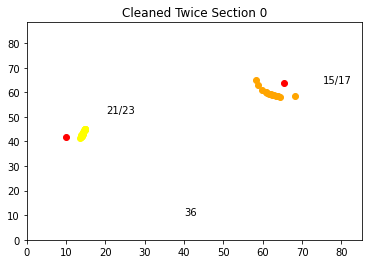

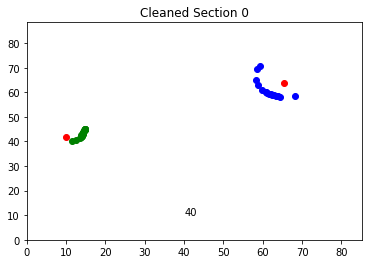

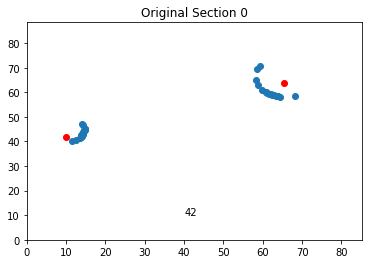

Circle 3 from Section 1 has no values.


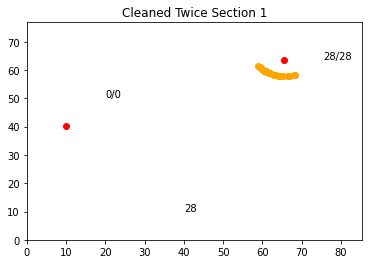

Circle 3 from Section 1 has no values


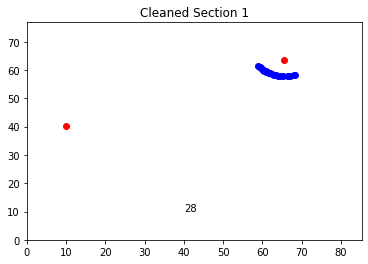

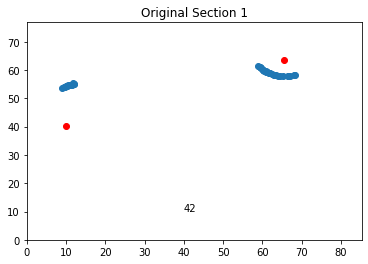

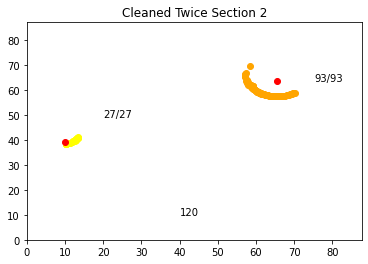

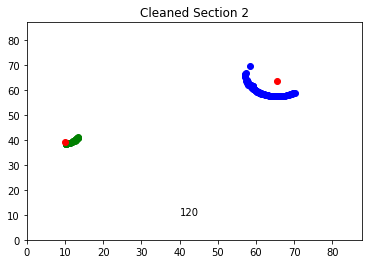

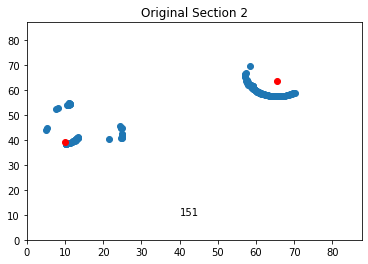

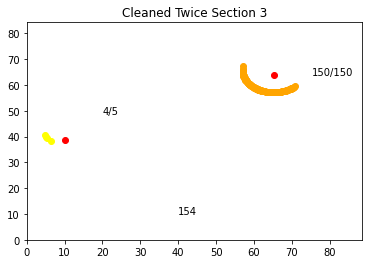

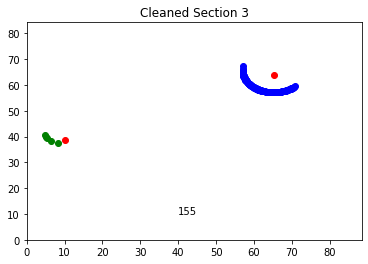

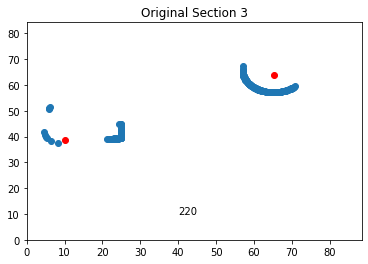

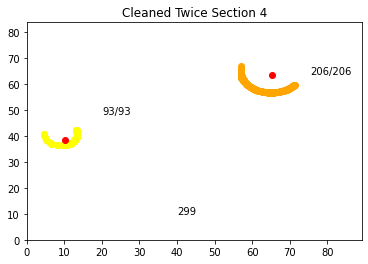

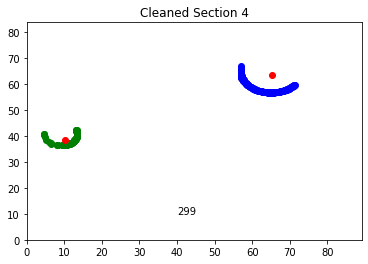

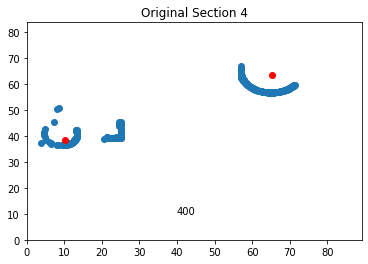

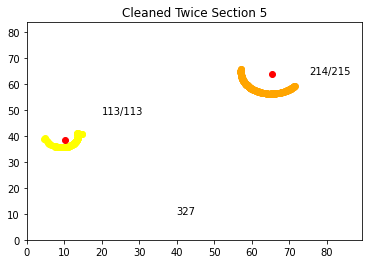

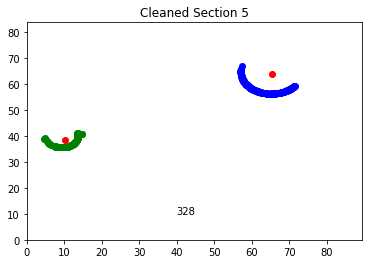

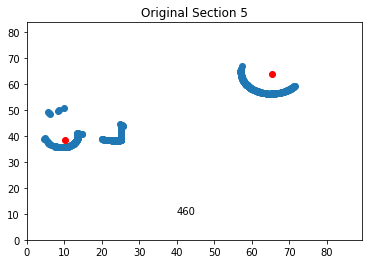

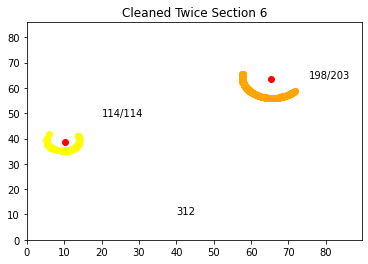

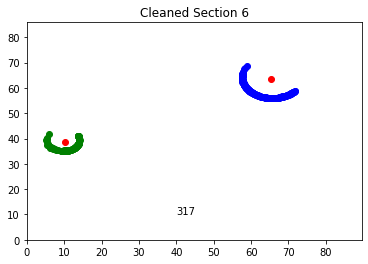

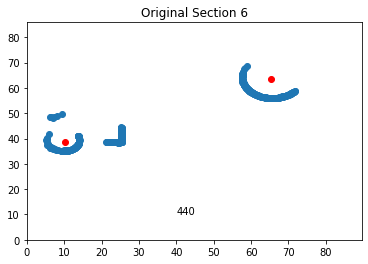

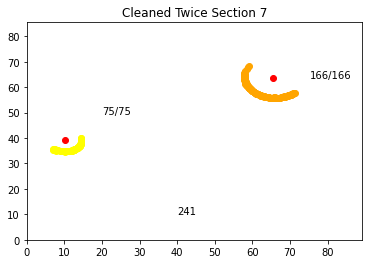

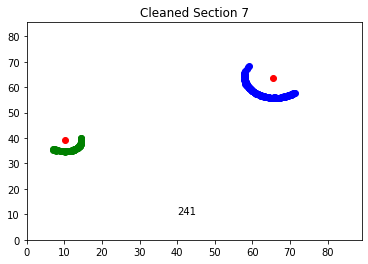

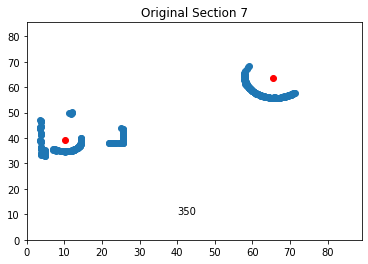

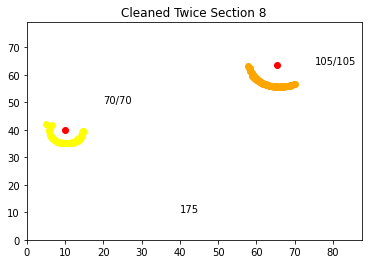

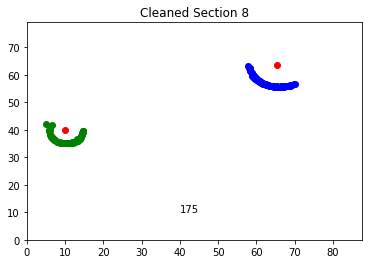

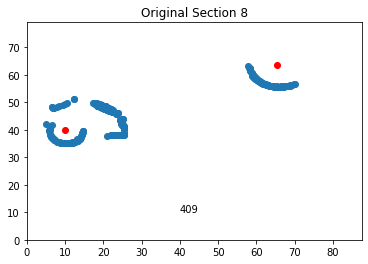

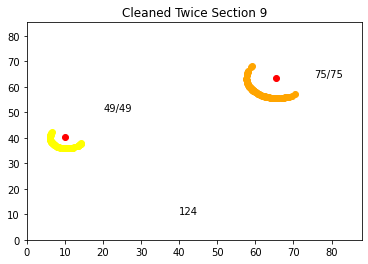

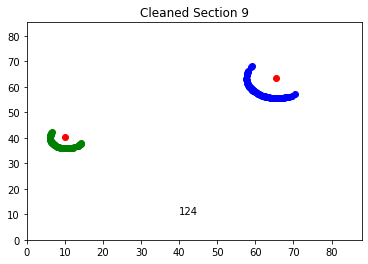

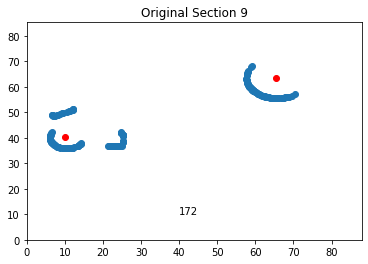

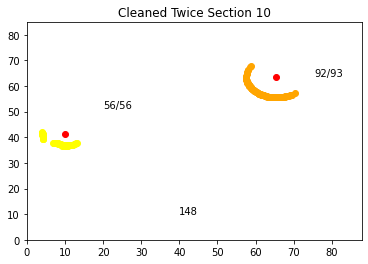

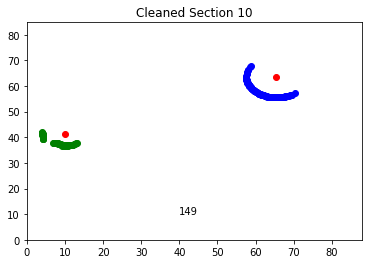

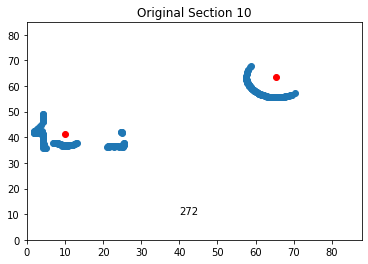

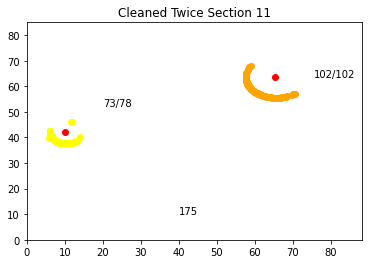

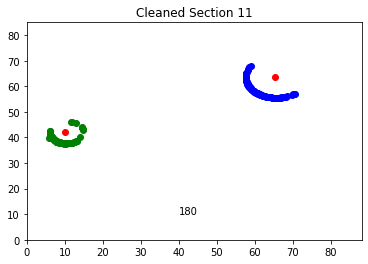

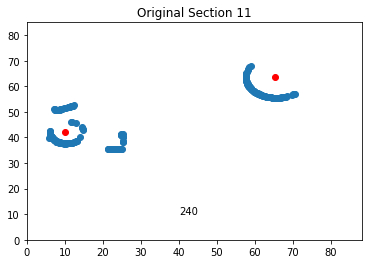

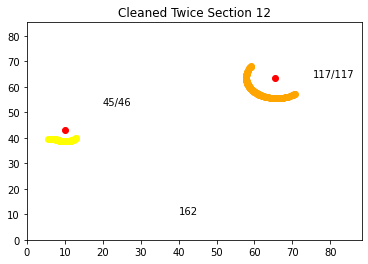

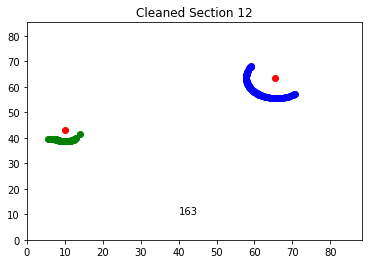

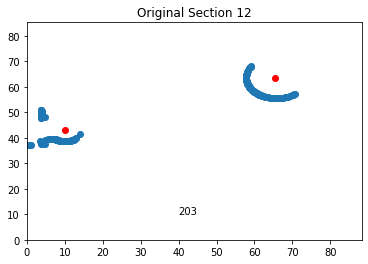

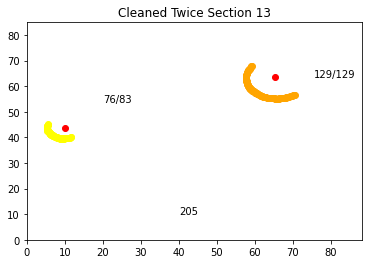

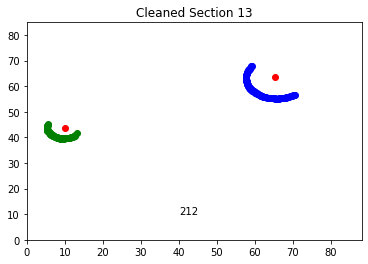

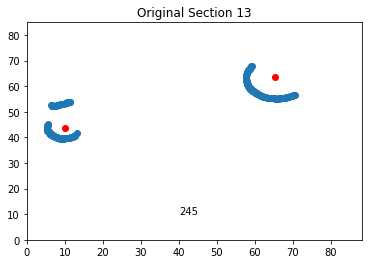

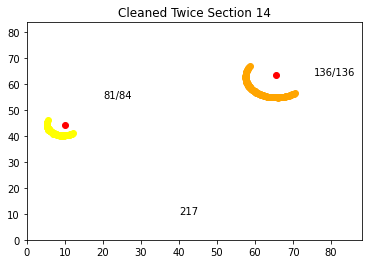

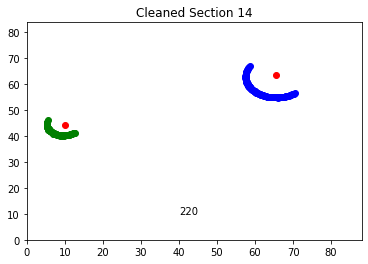

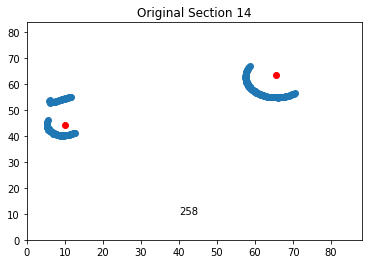

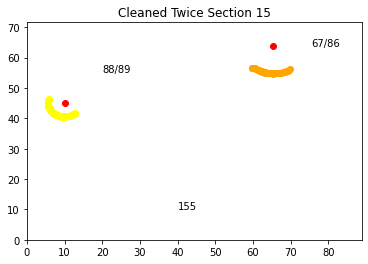

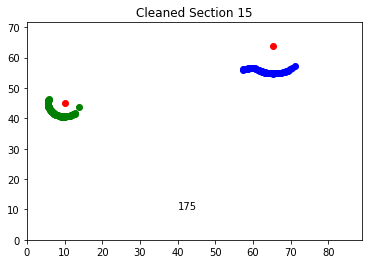

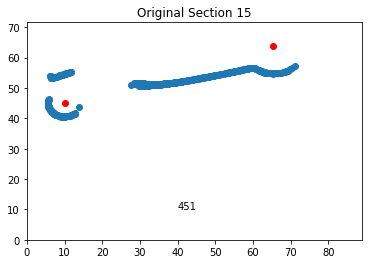

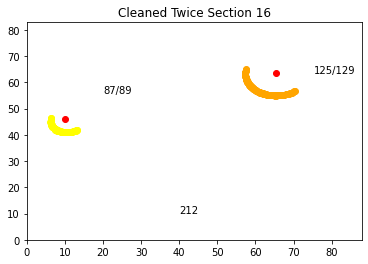

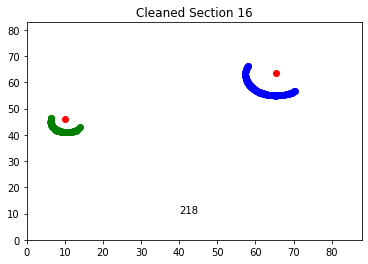

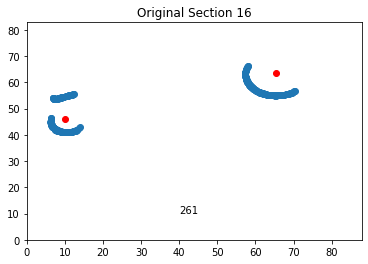

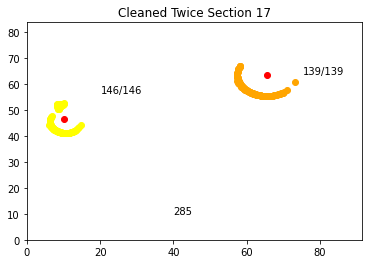

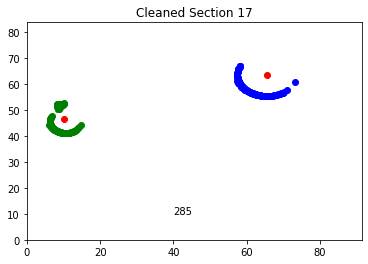

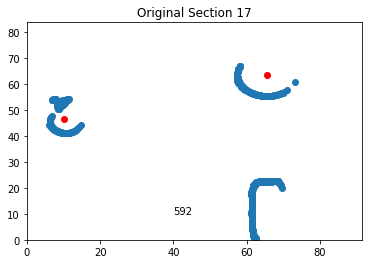

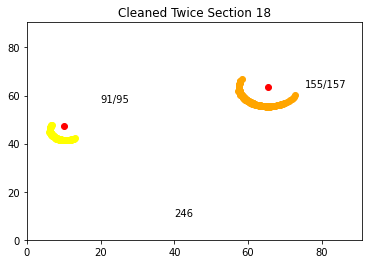

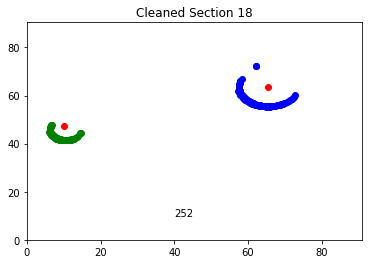

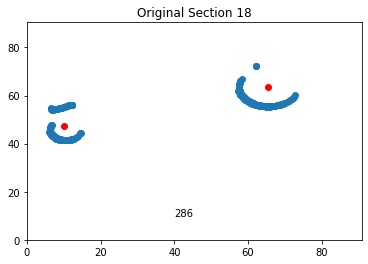

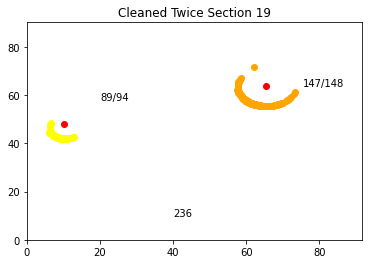

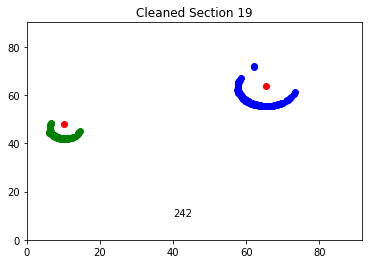

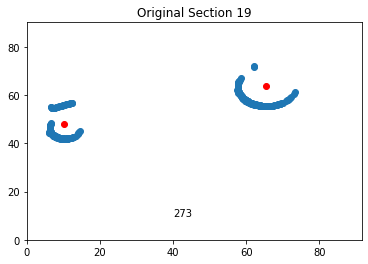

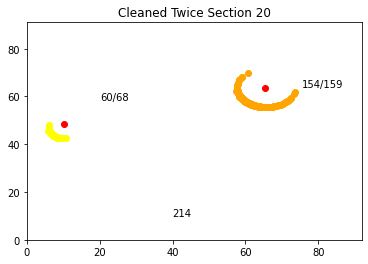

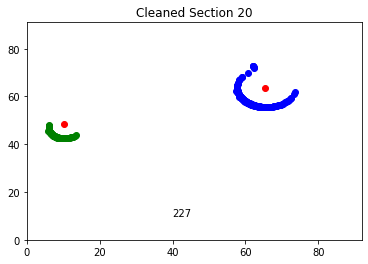

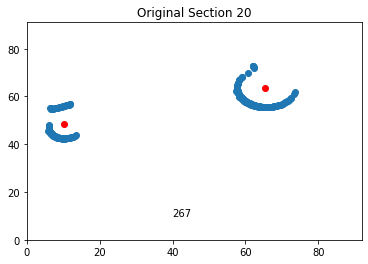

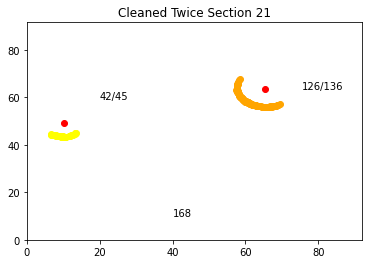

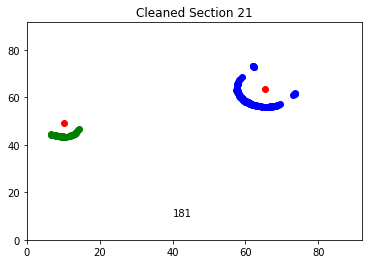

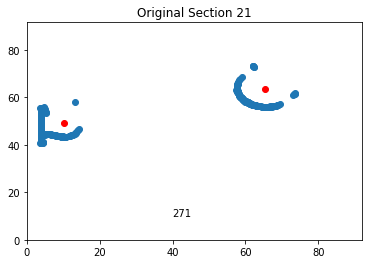

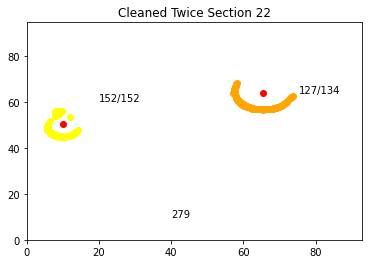

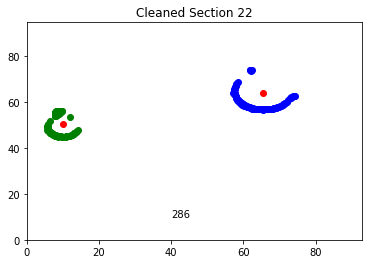

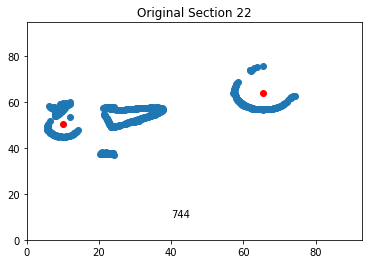

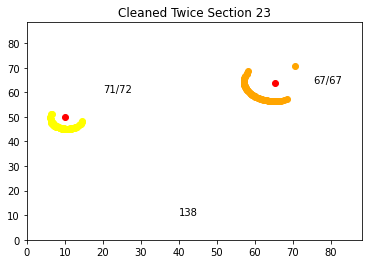

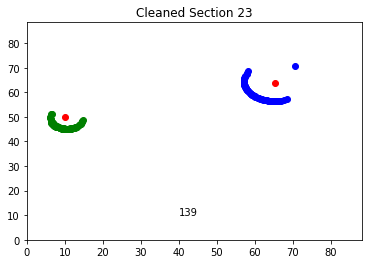

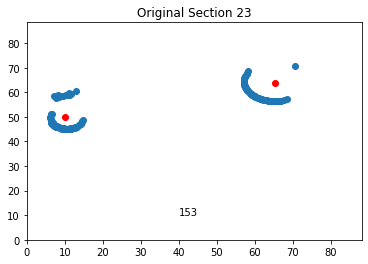

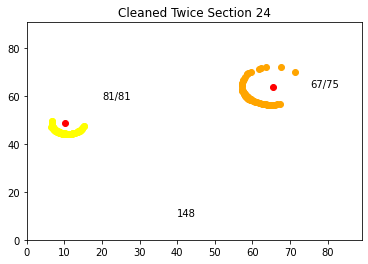

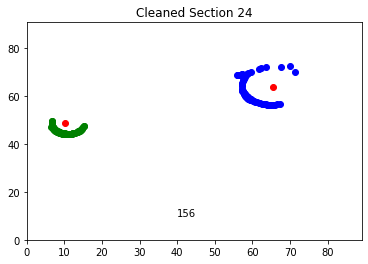

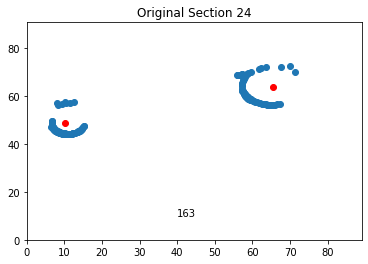

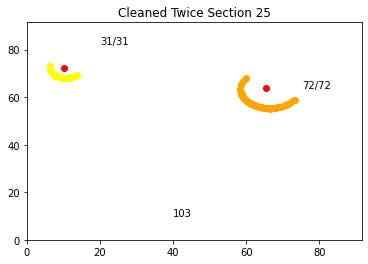

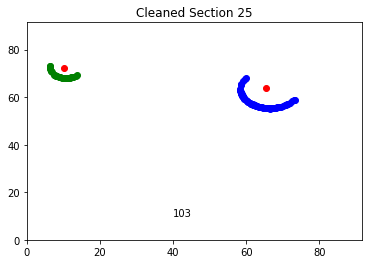

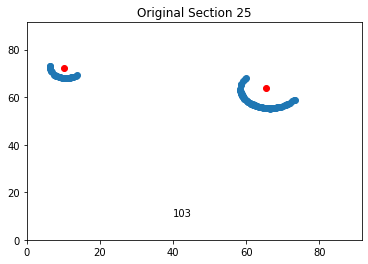

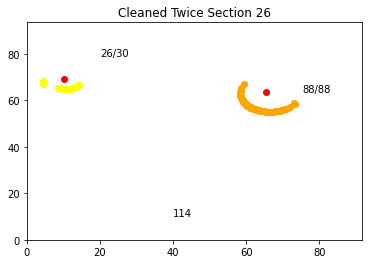

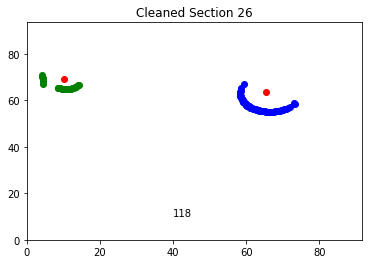

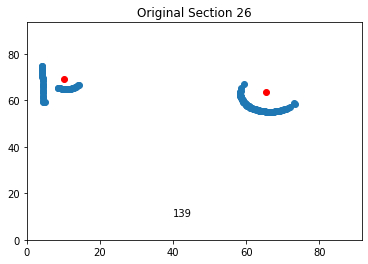

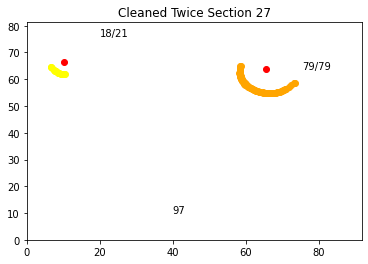

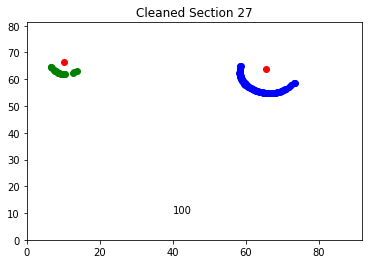

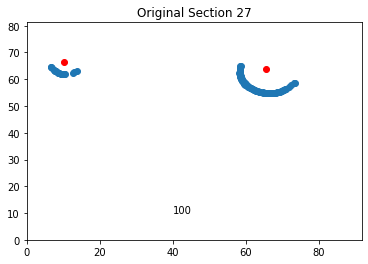

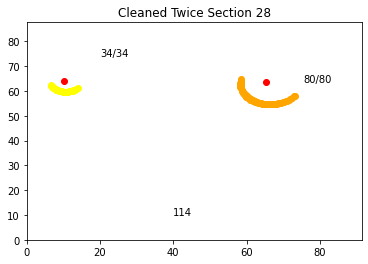

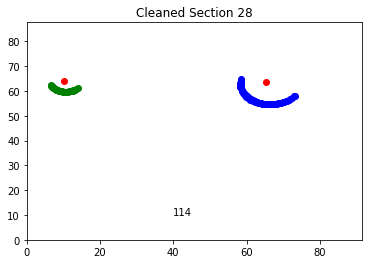

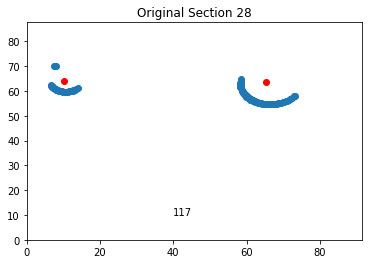

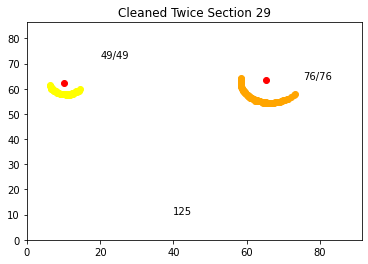

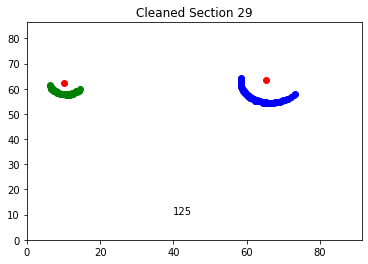

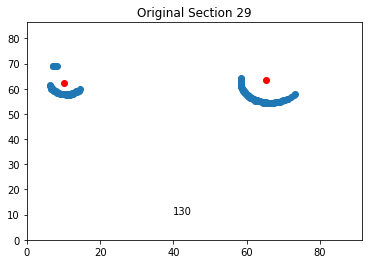

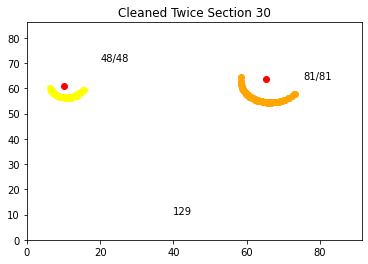

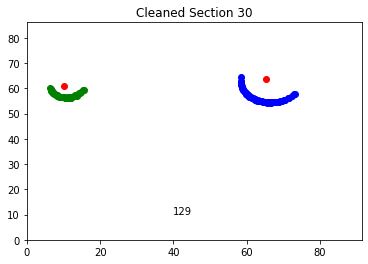

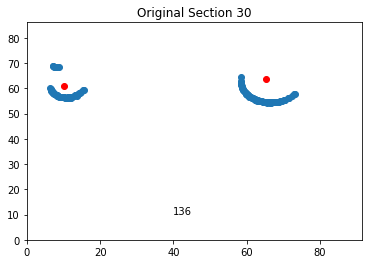

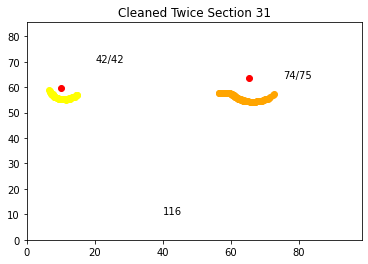

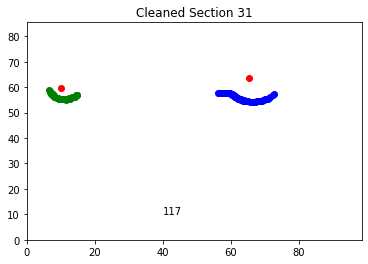

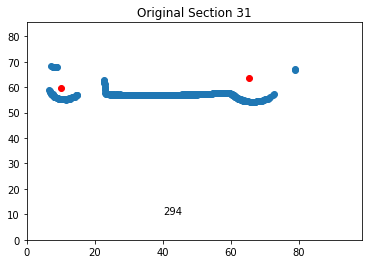

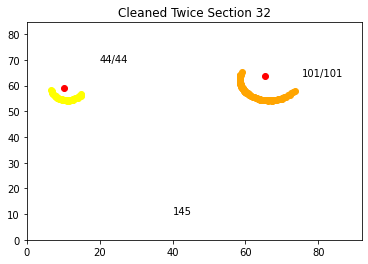

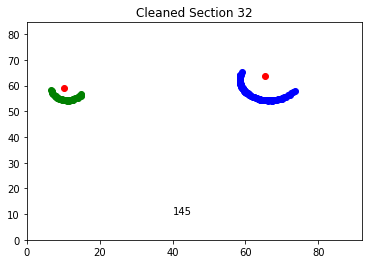

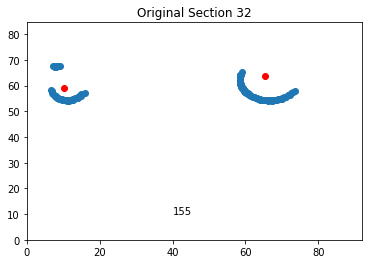

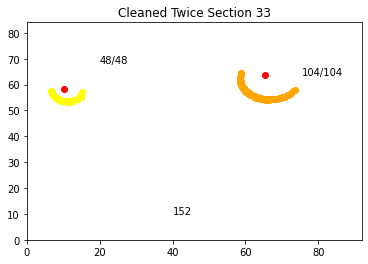

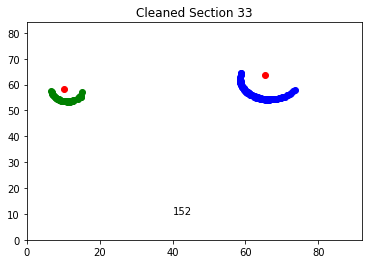

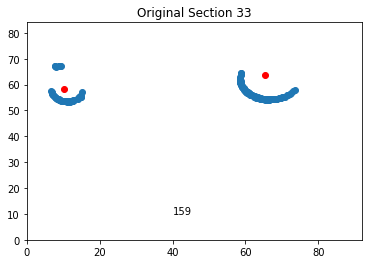

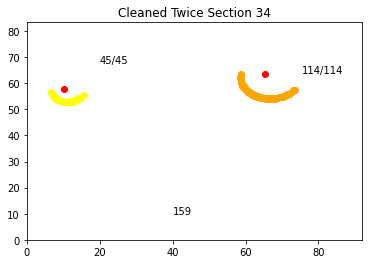

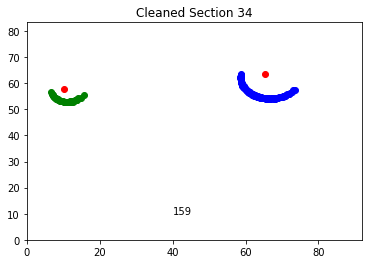

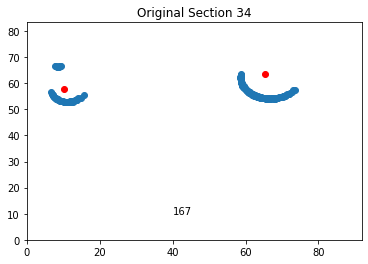

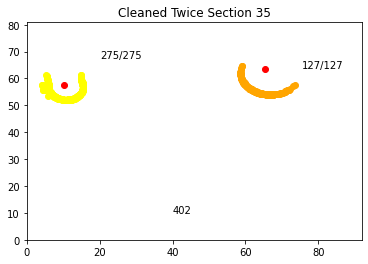

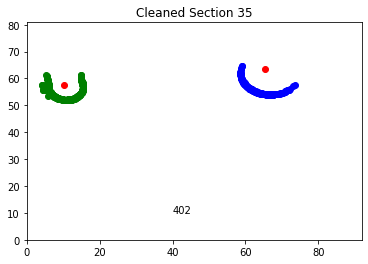

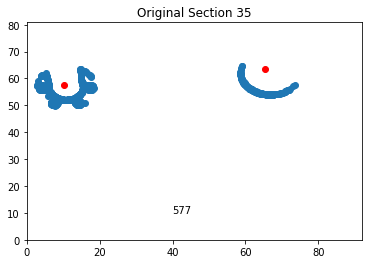

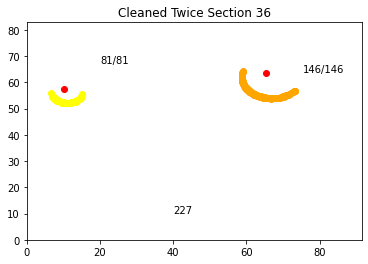

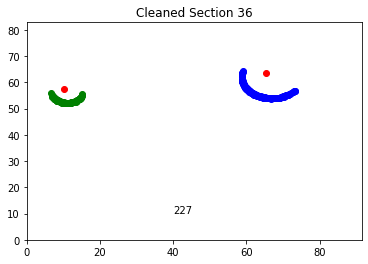

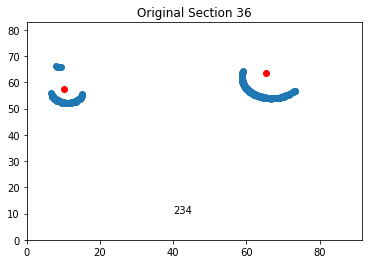

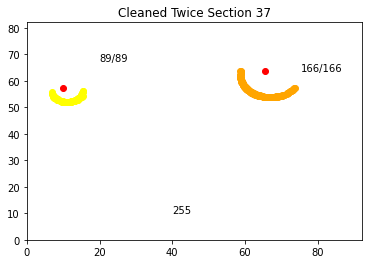

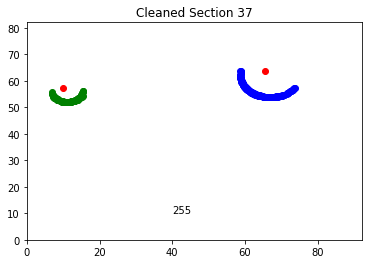

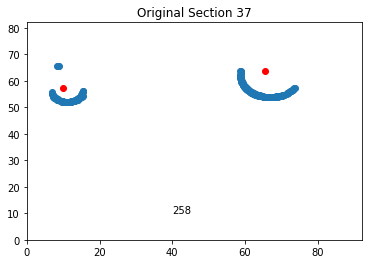

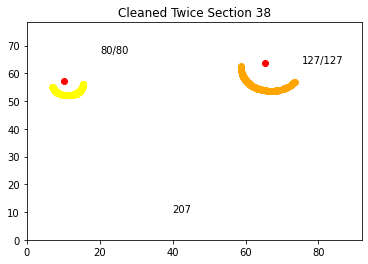

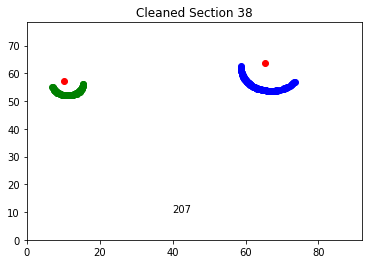

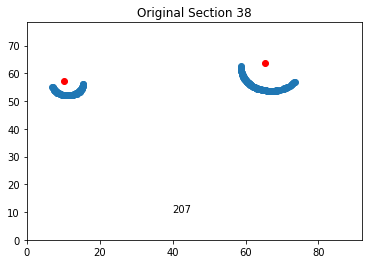

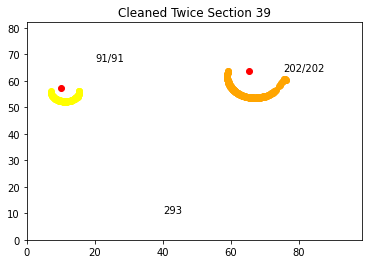

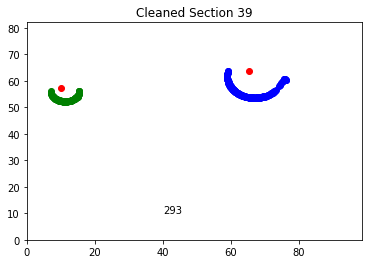

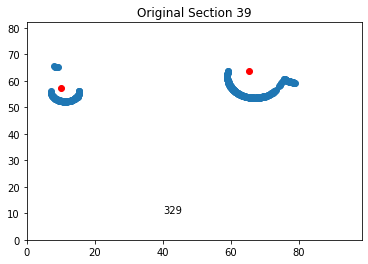

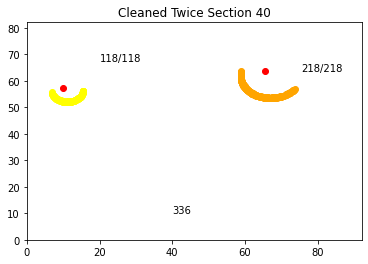

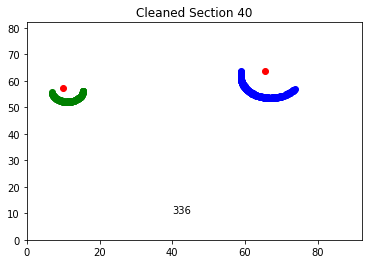

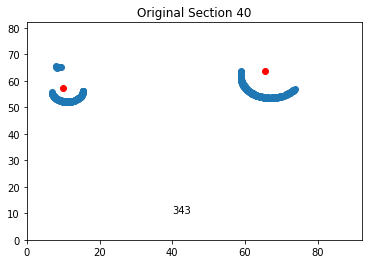

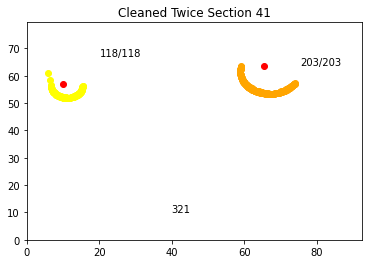

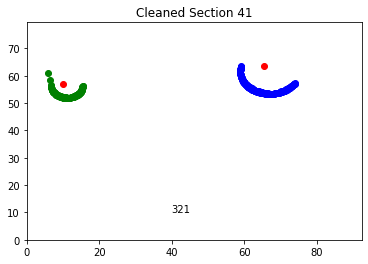

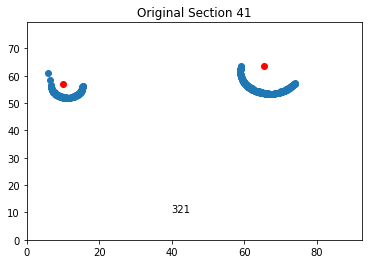

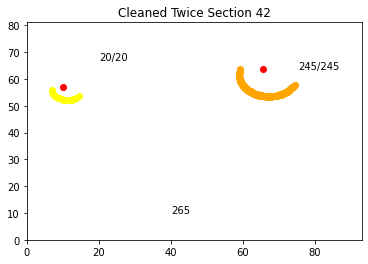

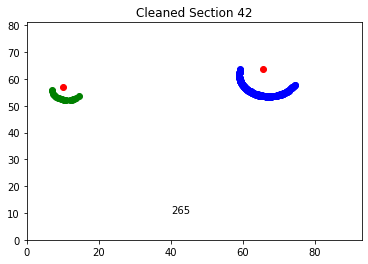

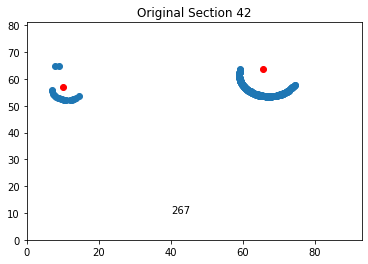

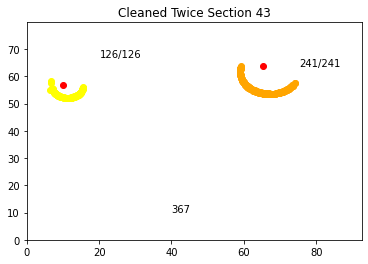

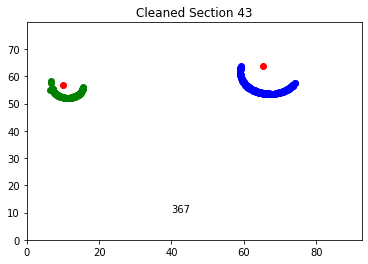

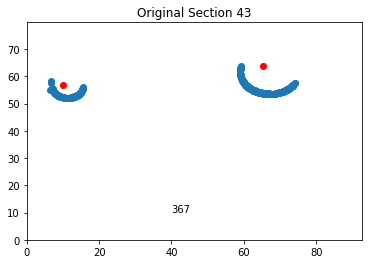

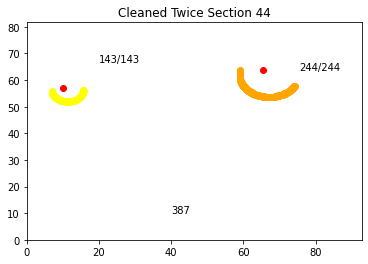

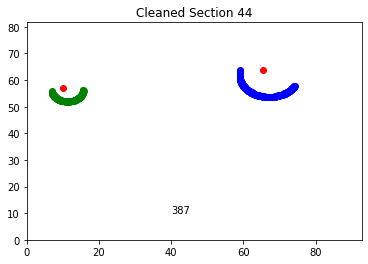

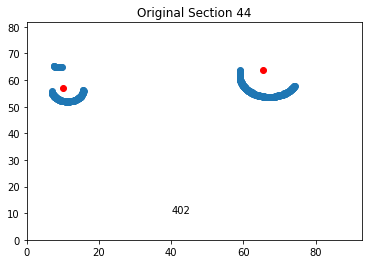

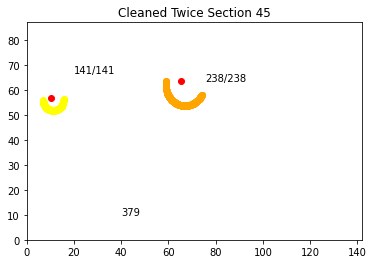

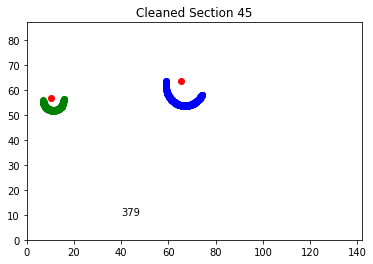

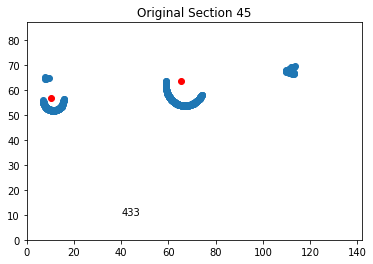

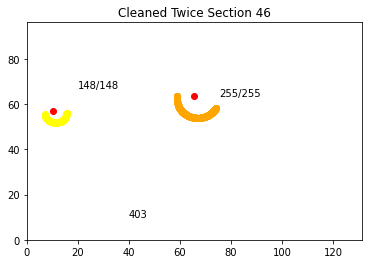

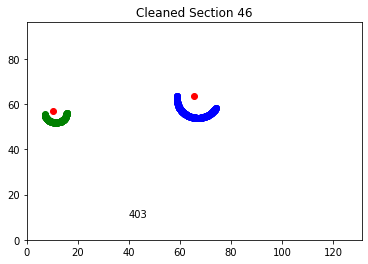

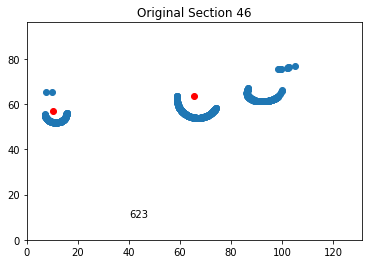

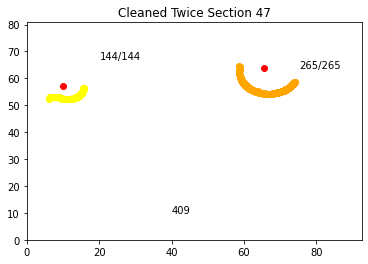

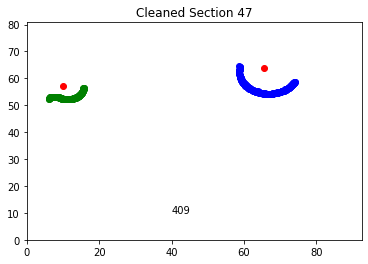

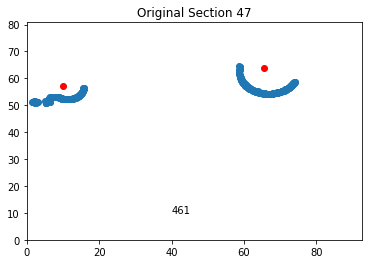

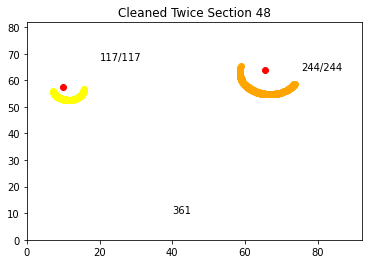

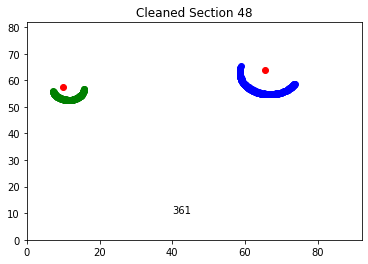

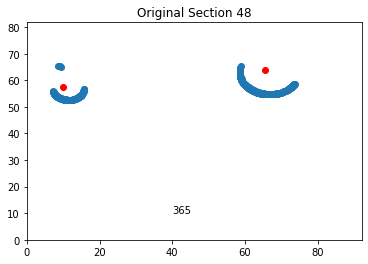

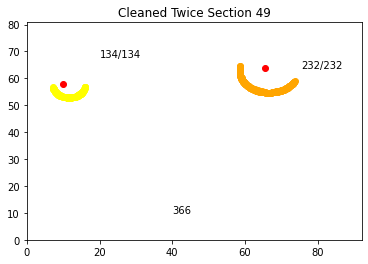

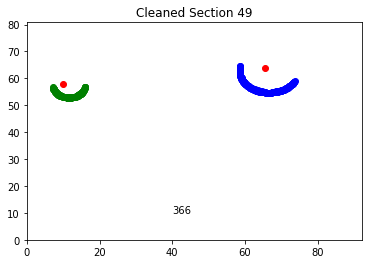

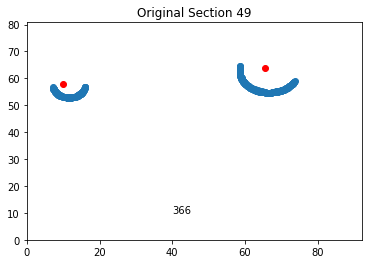

In [6]:
for NUM in range(0, 50):
    plt.title("Cleaned Twice Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = "orange") #Circle saved as D
    else: 
        print("Circle " + str(2 * NUM) + " from Section " + str(NUM) + " has no values.")

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + "/" + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]))

    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = "yellow")  #Circle saved as E
    else: 
        print("Circle " + str(2 * NUM + 1) + " from Section " + str(NUM) + " has no values.")

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + "/" + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10))

    plt.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()

    #Cleaned Section
    plt.title("Cleaned Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    if len(PassesFirstNoiseTestBySection[2 * NUM]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesFirstNoiseTestBySection[2 * NUM]), color = "blue") #Circle saved as D
    else: 
        print("Circle " + str(2 * NUM) + " from Section " + str(NUM) + " has no values")

    if len(PassesFirstNoiseTestBySection[2 * NUM + 1]) > 0: #Section 1 circle 3 workaround
        plt.scatter(*zip(*PassesFirstNoiseTestBySection[2 * NUM + 1]), color = "green")  #Circle saved as E
    else: 
        print("Circle " + str(2 * NUM + 1) + " from Section " + str(NUM) + " has no values")
    plt.annotate(str(len(PassesFirstNoiseTestBySection[2 * NUM]) + len(PassesFirstNoiseTestBySection[2 * NUM + 1])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()

    #Original Section
    plt.title("Original Section " + str(NUM))
    plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)
    plt.scatter(*zip(*TuplePairsBySection[NUM]))
    plt.annotate(str(len(TuplePairsBySection[NUM])), (40, 10))
    plt.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = "red")
    plt.show()

FACECOLOR = '#fffdfd'
FIGSIZE = (36,36)
TICK_LABELSIZE = 54
TICK_LENGTH = 24
TICK_WIDTH = 4
TITLE_FONTSIZE = 58
MARKER_SIZE = 544
ANNOTATE_SIZE = 34

for NUM in range(50):
    
    # Double cleaned sections---------------------------------------------------
    
    double_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    double_clean_section = double_clean_fig.add_subplot(1,1,1)
    double_clean_section.set_title('Cleaned Twice Section ' + str(NUM), fontsize = TITLE_FONTSIZE)
    double_clean_section.set_facecolor(FACECOLOR)
    double_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    double_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10), fontsize = ANNOTATE_SIZE)
    double_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange', s = MARKER_SIZE) #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]), fontsize = ANNOTATE_SIZE)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        double_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow', s = MARKER_SIZE)  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10), fontsize = ANNOTATE_SIZE)
    double_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10), fontsize = ANNOTATE_SIZE)
    double_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #double_clean_fig.savefig('Results/Cleaned_Twice_Sections/cleaned_twice_section_' + str(NUM) + '.png', facecolor = double_clean_fig.get_facecolor())
    
    # Single cleaned sections---------------------------------------------------
    
    single_clean_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    single_clean_section = single_clean_fig.add_subplot(1,1,1)
    single_clean_section.set_title('Cleaned Once Section ' + str(NUM), fontsize = TITLE_FONTSIZE)
    single_clean_section.set_facecolor(FACECOLOR)
    single_clean_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    single_clean_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10), fontsize = ANNOTATE_SIZE)
    single_clean_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM]), color = 'orange', s = MARKER_SIZE) #Circle saved as D
    else: 
        print('Circle ' + str(2 * NUM) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM])),
                 (CenterList[NUM].iloc[0,1] + 10, CenterList[NUM].iloc[0,2]), fontsize = ANNOTATE_SIZE)
    
    # Section 1 circle 3 workaround
    
    if len(PassesSecondNoiseTestBySection[2 * NUM + 1]) > 0: 
        single_clean_section.scatter(*zip(*PassesSecondNoiseTestBySection[2 * NUM + 1]), color = 'yellow', s = MARKER_SIZE)  #Circle saved as E
    else: 
        print('Circle ' + str(2 * NUM + 1) + ' from Section ' + str(NUM) + ' has no values.')

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM + 1])) + '/' + str(len(PassesFirstNoiseTestBySection[2 * NUM + 1])),
                  (CenterList[NUM].iloc[1,1] + 10, CenterList[NUM].iloc[1,2] + 10), fontsize = ANNOTATE_SIZE)

    single_clean_section.annotate(str(len(PassesSecondNoiseTestBySection[2 * NUM]) + len(PassesSecondNoiseTestBySection[2 * NUM + 1])), (40, 10), fontsize = ANNOTATE_SIZE)
    single_clean_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #single_clean_fig.savefig('Results/Cleaned_Once_Sections/cleaned_once_section_' + str(NUM) + '.png', facecolor = single_clean_fig.get_facecolor())
    
    
    # Original Section----------------------------------------------------------
    
    original_fig = plt.figure(figsize = FIGSIZE, facecolor = FACECOLOR)
    original_section = original_fig.add_subplot(1,1,1)
    original_section.set_title('Original Section ' + str(NUM), fontsize = TITLE_FONTSIZE)
    original_section.set_facecolor(FACECOLOR)
    original_section.scatter(*zip(*TuplePairsBySection[NUM]), s = MARKER_SIZE)
    original_section.scatter(CenterList[NUM].X, CenterList[NUM].Y, color = 'red', s = MARKER_SIZE)
    original_section.annotate(str(len(TuplePairsBySection[NUM])), (40, 10), fontsize = ANNOTATE_SIZE)
    original_section.tick_params(labelsize = TICK_LABELSIZE, length = TICK_LENGTH, width = TICK_WIDTH)
    
    # save final figure
    # Uncomment following line when ready to save images
    
    #original_fig.savefig('Results/Original_Sections/original_section_' + str(NUM) + '.png', facecolor = original_fig.get_facecolor())
    
    # Incase these lines are needed 
    #plt.xlim(0, max(x[0] for x in TuplePairsBySection[NUM]) * 1.25)
    #plt.ylim(0, max(y[1] for y in TuplePairsBySection[NUM]) * 1.25)

In [7]:
print(PassesSecondNoiseTestBySection[0])

[(61.61, 59.48), (60.87, 60.03), (58.78, 62.92), (61.97, 59.21), (58.19, 64.98), (61.14, 59.77), (59.88, 60.98), (60.94, 59.96), (68.11, 58.33), (62.83, 58.74), (63.58, 58.41), (63.94, 58.34), (62.24, 59.01), (63.39, 58.53), (64.37, 58.26)]


In [8]:
def printInfo(radius, Xcp, Ycp, secNum, pipeCount):
    #round values
    roundList = [radius, Xcp, Ycp]
    roundList = [round(i, 6) for i in roundList]
    radius = roundList[0]
    Xcp = roundList[1]
    Ycp = roundList[2]
    FCP = (Xcp, Ycp)
    givenR = CenterList[secNum].iloc[pipeCount,4]
    givenC_tuple = tuple(CenterList[secNum].iloc[pipeCount,1:3])
    print("The fitted center point is: (" + str(Xcp) + "," + str(Ycp) + ")")
    print("The as-designed center point is: (" + str(givenC_tuple[0]) + "," + str(givenC_tuple[1]) + ")")
    print("The distance between them is: " + str(round(math.dist(givenC_tuple, FCP), 7)))
    print("The fitted radius is: " + str(radius) + " and the actual radius is: " + str(givenR))
    print("The difference between them is: " + str(round(abs(givenR - radius), 7)))

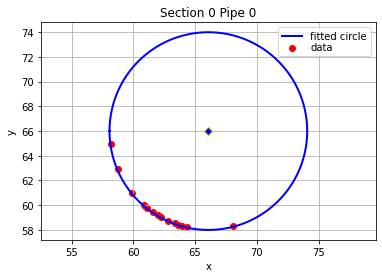

The fitted center point is: (66.075084,65.99213)
The as-designed center point is: (65.408948,63.690596)
The distance between them is: 2.3959958
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


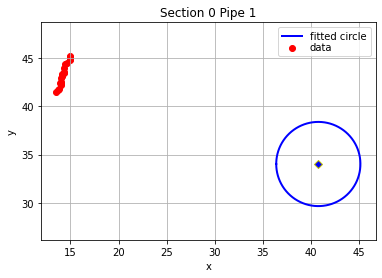

The fitted center point is: (40.75894,34.022284)
The as-designed center point is: (10.082133,41.693907)
The distance between them is: 31.6215162
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


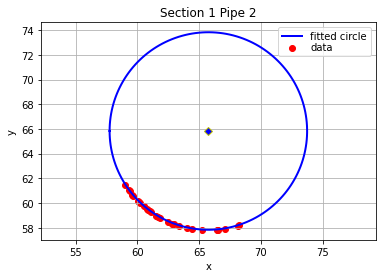

The fitted center point is: (65.746915,65.832684)
The as-designed center point is: (65.408948,63.690228)
The distance between them is: 2.1689489
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


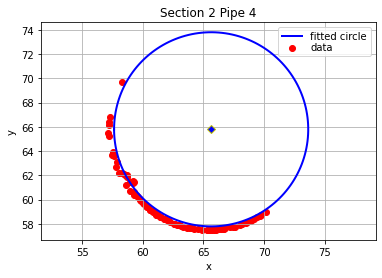

The fitted center point is: (65.630768,65.790471)
The as-designed center point is: (65.408948,63.688344)
The distance between them is: 2.113798
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


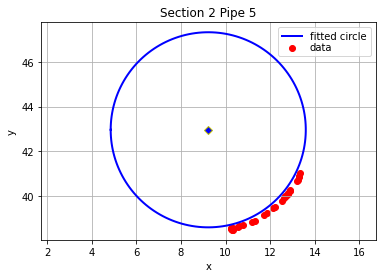

The fitted center point is: (9.2216,42.960564)
The as-designed center point is: (10.08213,39.285477)
The distance between them is: 3.7744902
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


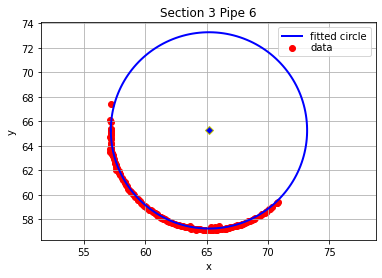

The fitted center point is: (65.189393,65.262365)
The as-designed center point is: (65.408948,63.691962)
The distance between them is: 1.5856765
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


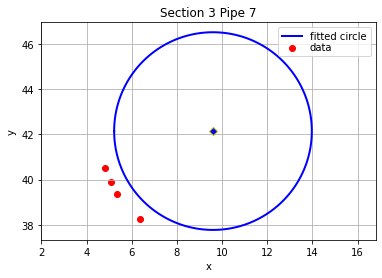

The fitted center point is: (9.595466,42.146359)
The as-designed center point is: (10.082139,38.654272)
The distance between them is: 3.5258364
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


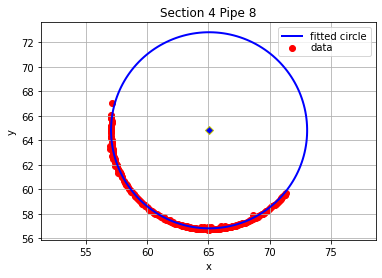

The fitted center point is: (65.049605,64.818093)
The as-designed center point is: (65.408948,63.686064)
The distance between them is: 1.187694
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


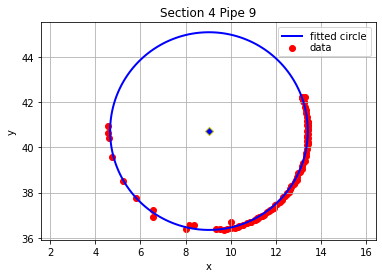

The fitted center point is: (9.032392,40.724409)
The as-designed center point is: (10.082159,38.36009)
The distance between them is: 2.5868929
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


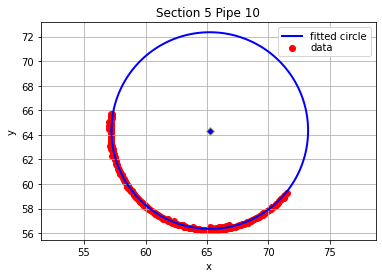

The fitted center point is: (65.228177,64.354584)
The as-designed center point is: (65.408947,63.692365)
The distance between them is: 0.6864487
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


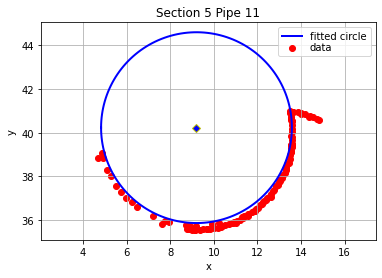

The fitted center point is: (9.206434,40.230101)
The as-designed center point is: (10.082174,38.413142)
The distance between them is: 2.0169929
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


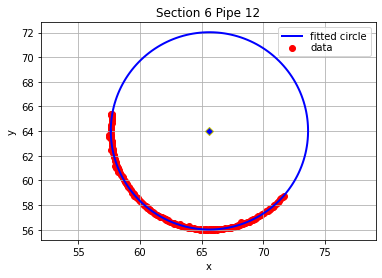

The fitted center point is: (65.632864,64.021345)
The as-designed center point is: (65.408948,63.689478)
The distance between them is: 0.4003425
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


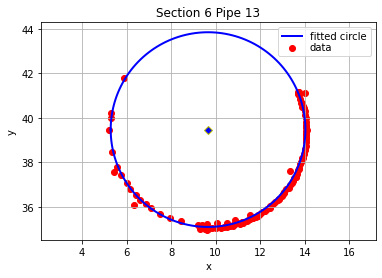

The fitted center point is: (9.656898,39.47846)
The as-designed center point is: (10.082196,38.720377)
The distance between them is: 0.8692343
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


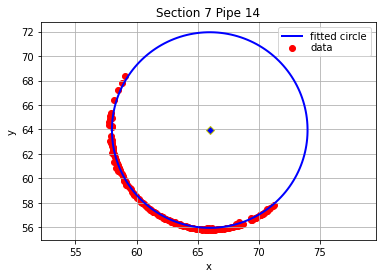

The fitted center point is: (65.986759,63.948496)
The as-designed center point is: (65.408948,63.689696)
The distance between them is: 0.6331216
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


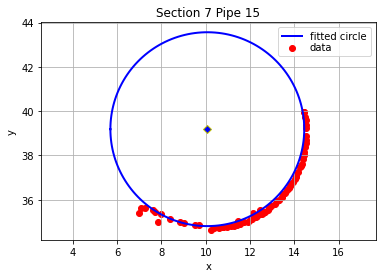

The fitted center point is: (10.073495,39.187152)
The as-designed center point is: (10.082214,39.186475)
The distance between them is: 0.0087452
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


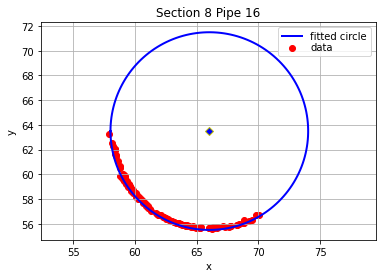

The fitted center point is: (66.026353,63.499709)
The as-designed center point is: (65.408947,63.688186)
The distance between them is: 0.6455337
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


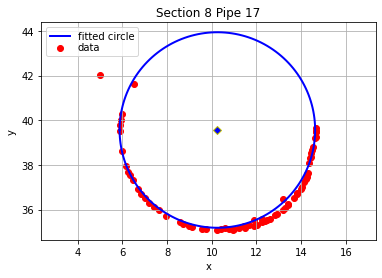

The fitted center point is: (10.248783,39.561068)
The as-designed center point is: (10.082227,39.797709)
The distance between them is: 0.2893784
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


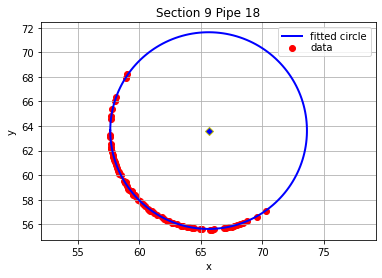

The fitted center point is: (65.639266,63.629931)
The as-designed center point is: (65.408949,63.69204)
The distance between them is: 0.2385444
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


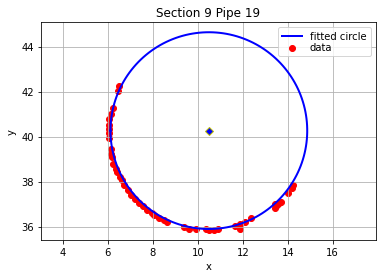

The fitted center point is: (10.490392,40.266165)
The as-designed center point is: (10.082258,40.52607)
The distance between them is: 0.4838636
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


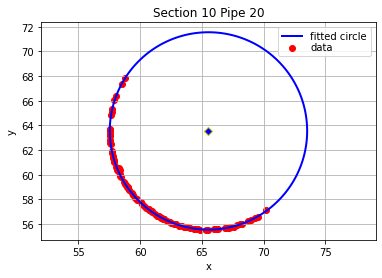

The fitted center point is: (65.537381,63.553594)
The as-designed center point is: (65.408947,63.689229)
The distance between them is: 0.1867944
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


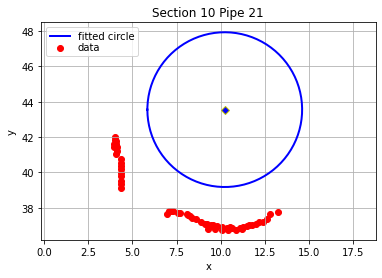

The fitted center point is: (10.222839,43.550713)
The as-designed center point is: (10.082269,41.290486)
The distance between them is: 2.264594
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


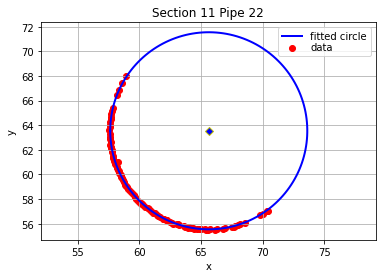

The fitted center point is: (65.624848,63.548869)
The as-designed center point is: (65.408948,63.68858)
The distance between them is: 0.2571614
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


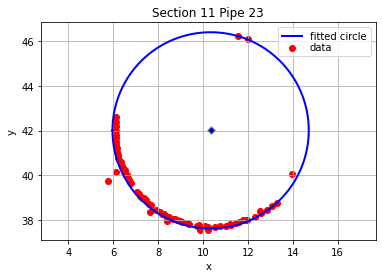

The fitted center point is: (10.337248,42.007836)
The as-designed center point is: (10.082281,42.084443)
The distance between them is: 0.266227
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


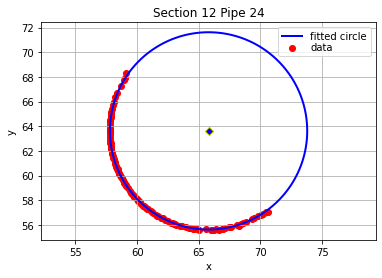

The fitted center point is: (65.793063,63.620351)
The as-designed center point is: (65.408948,63.689727)
The distance between them is: 0.3903298
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


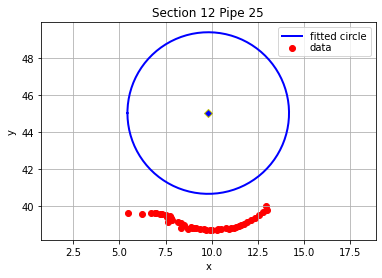

The fitted center point is: (9.810973,45.01782)
The as-designed center point is: (10.082301,42.906137)
The distance between them is: 2.129043
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


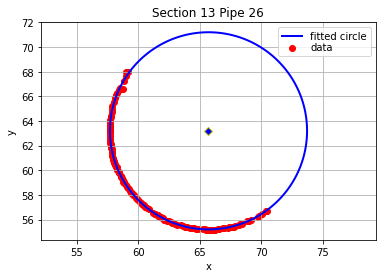

The fitted center point is: (65.701715,63.203269)
The as-designed center point is: (65.408952,63.690076)
The distance between them is: 0.5680592
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


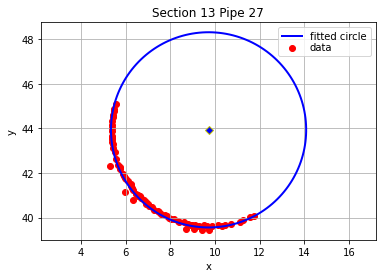

The fitted center point is: (9.714834,43.93597)
The as-designed center point is: (10.082316,43.687625)
The distance between them is: 0.4435293
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


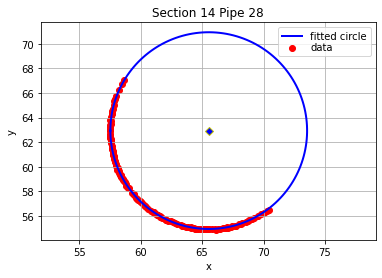

The fitted center point is: (65.540329,62.946448)
The as-designed center point is: (65.408924,63.689659)
The distance between them is: 0.7547383
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


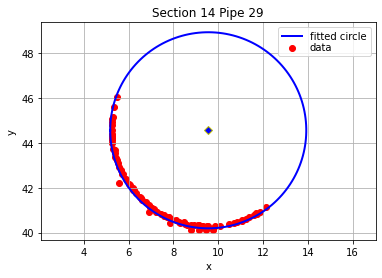

The fitted center point is: (9.55331,44.565989)
The as-designed center point is: (10.082326,44.444329)
The distance between them is: 0.5428251
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


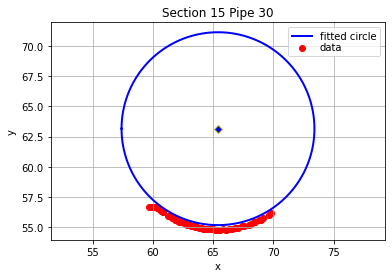

The fitted center point is: (65.407769,63.157816)
The as-designed center point is: (65.408993,63.690284)
The distance between them is: 0.5324694
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


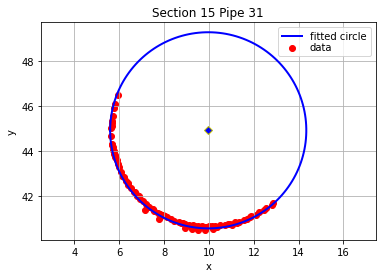

The fitted center point is: (9.965927,44.923081)
The as-designed center point is: (10.082381,45.177773)
The distance between them is: 0.2800528
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


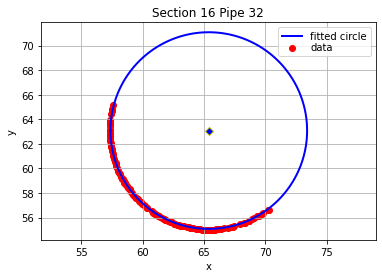

The fitted center point is: (65.38744,63.082502)
The as-designed center point is: (65.408901,63.688543)
The distance between them is: 0.6064209
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


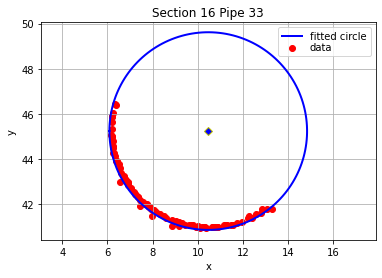

The fitted center point is: (10.462783,45.238456)
The as-designed center point is: (10.082121,45.884234)
The distance between them is: 0.7496218
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


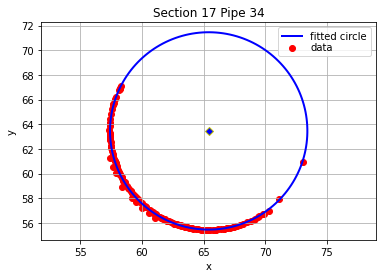

The fitted center point is: (65.413605,63.456051)
The as-designed center point is: (65.40897,63.691072)
The distance between them is: 0.2350667
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


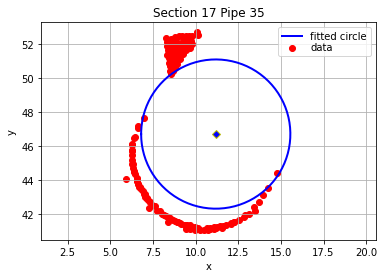

The fitted center point is: (11.181696,46.710164)
The as-designed center point is: (10.082129,46.573794)
The distance between them is: 1.1079911
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


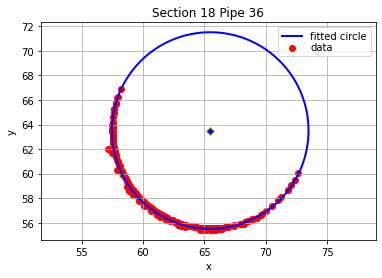

The fitted center point is: (65.475729,63.510995)
The as-designed center point is: (65.408959,63.690774)
The distance between them is: 0.1917778
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


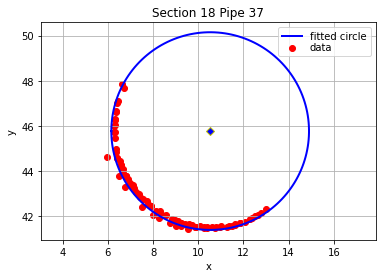

The fitted center point is: (10.526556,45.770556)
The as-designed center point is: (10.082411,47.244838)
The distance between them is: 1.5397312
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


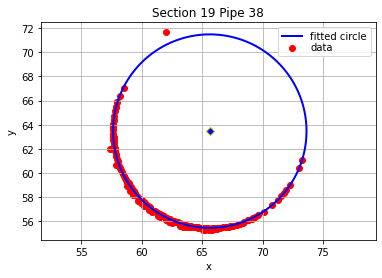

The fitted center point is: (65.635351,63.47338)
The as-designed center point is: (65.408918,63.678573)
The distance between them is: 0.305575
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


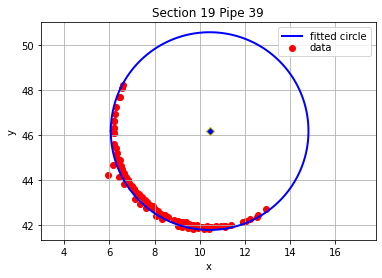

The fitted center point is: (10.438343,46.17498)
The as-designed center point is: (10.08238,47.924377)
The distance between them is: 1.7852449
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


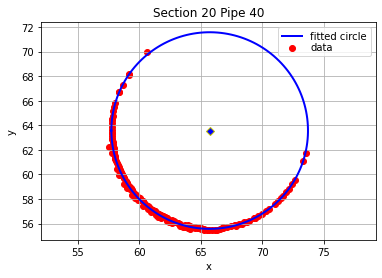

The fitted center point is: (65.735035,63.576451)
The as-designed center point is: (65.408993,63.725069)
The distance between them is: 0.3583165
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


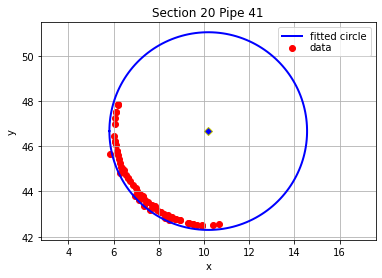

The fitted center point is: (10.186288,46.673404)
The as-designed center point is: (10.082403,48.612812)
The distance between them is: 1.9421883
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


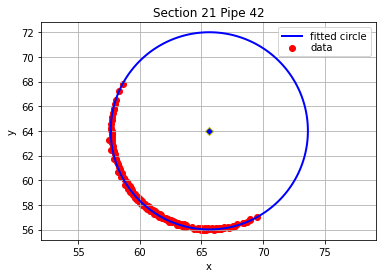

The fitted center point is: (65.63343,64.008847)
The as-designed center point is: (65.408892,63.636728)
The distance between them is: 0.4346146
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


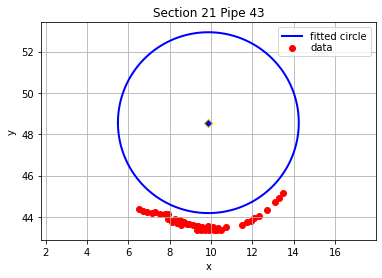

The fitted center point is: (9.879092,48.559525)
The as-designed center point is: (10.082445,49.31519)
The distance between them is: 0.7825484
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


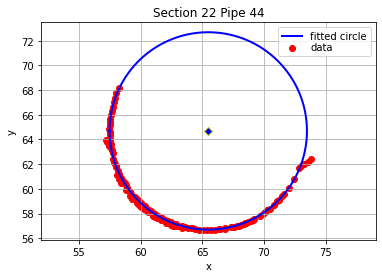

The fitted center point is: (65.482298,64.694542)
The as-designed center point is: (65.408988,63.715005)
The distance between them is: 0.9822765
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


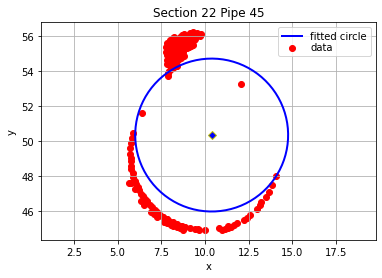

The fitted center point is: (10.383936,50.327998)
The as-designed center point is: (10.082591,50.16763)
The distance between them is: 0.3413601
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


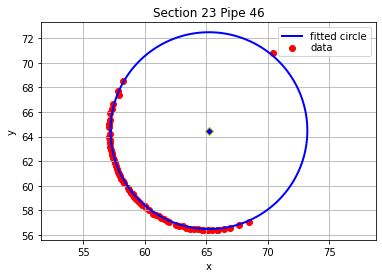

The fitted center point is: (65.223,64.479253)
The as-designed center point is: (65.40894,63.68693)
The distance between them is: 0.8138485
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


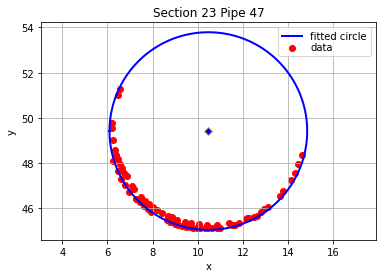

The fitted center point is: (10.467965,49.41493)
The as-designed center point is: (10.082391,50.094509)
The distance between them is: 0.7813417
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


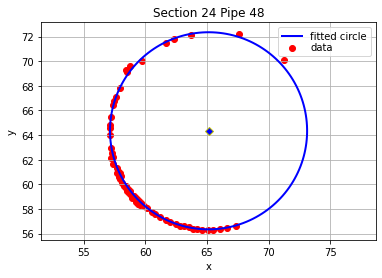

The fitted center point is: (65.122586,64.346229)
The as-designed center point is: (65.408944,63.688418)
The distance between them is: 0.7174373
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


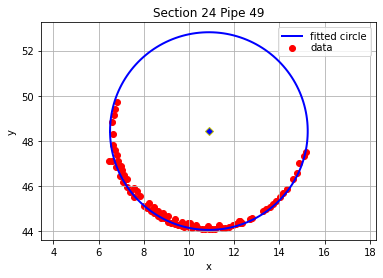

The fitted center point is: (10.881135,48.438932)
The as-designed center point is: (10.082476,48.592237)
The distance between them is: 0.8132396
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


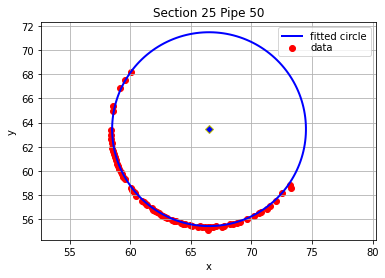

The fitted center point is: (66.50231,63.458451)
The as-designed center point is: (65.408948,63.6897)
The distance between them is: 1.1175494
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


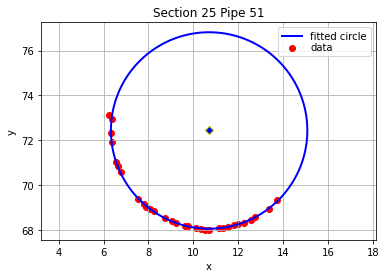

The fitted center point is: (10.702605,72.44023)
The as-designed center point is: (10.07984,72.187847)
The distance between them is: 0.6719624
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


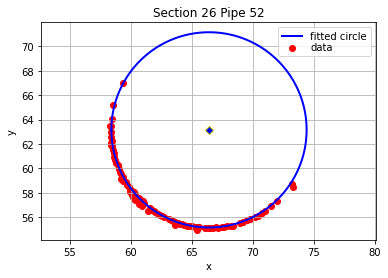

The fitted center point is: (66.412985,63.158606)
The as-designed center point is: (65.408948,63.689577)
The distance between them is: 1.1357907
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


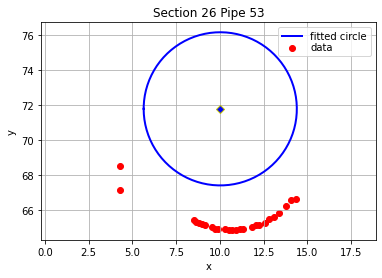

The fitted center point is: (10.022826,71.776915)
The as-designed center point is: (10.080441,69.043439)
The distance between them is: 2.7340831
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


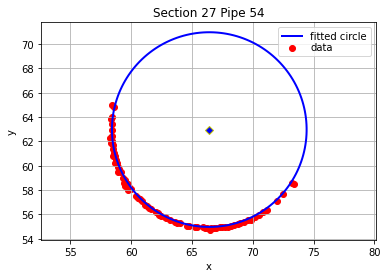

The fitted center point is: (66.422494,62.966597)
The as-designed center point is: (65.408949,63.689785)
The distance between them is: 1.2451001
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


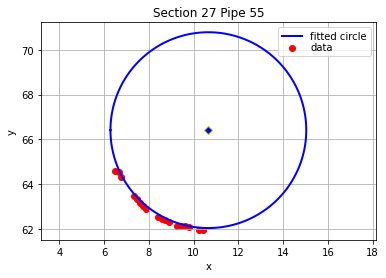

The fitted center point is: (10.658947,66.4086)
The as-designed center point is: (10.081235,66.270062)
The distance between them is: 0.5940908
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


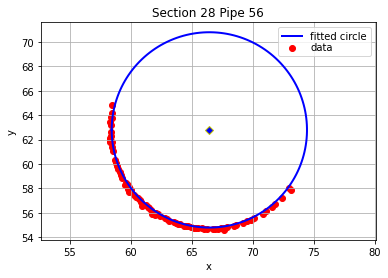

The fitted center point is: (66.430752,62.794295)
The as-designed center point is: (65.408948,63.689812)
The distance between them is: 1.3586884
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


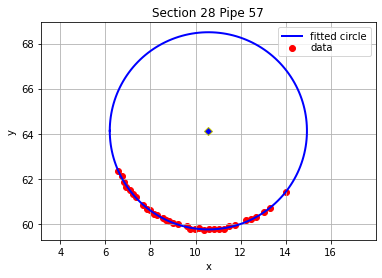

The fitted center point is: (10.568798,64.127407)
The as-designed center point is: (10.081893,63.977636)
The distance between them is: 0.5094191
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


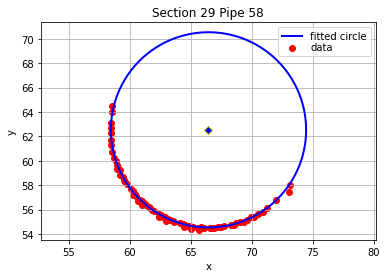

The fitted center point is: (66.452383,62.531018)
The as-designed center point is: (65.408948,63.690343)
The distance between them is: 1.5597407
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


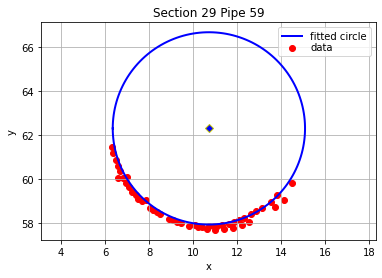

The fitted center point is: (10.723137,62.289681)
The as-designed center point is: (10.082405,62.12921)
The distance between them is: 0.6605213
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


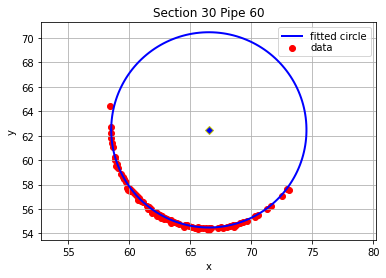

The fitted center point is: (66.508193,62.477766)
The as-designed center point is: (65.408949,63.688414)
The distance between them is: 1.6352388
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


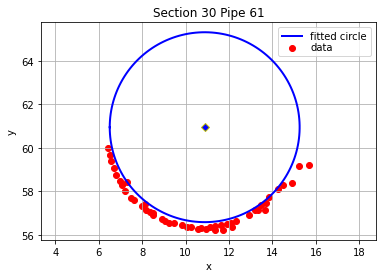

The fitted center point is: (10.876075,60.953138)
The as-designed center point is: (10.08278,60.705438)
The distance between them is: 0.8310669
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


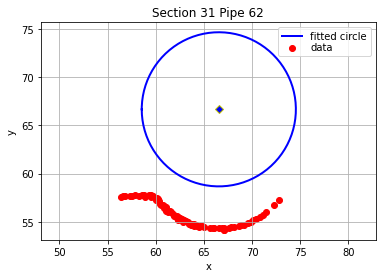

The fitted center point is: (66.548891,66.668163)
The as-designed center point is: (65.408948,63.690452)
The distance between them is: 3.188453
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


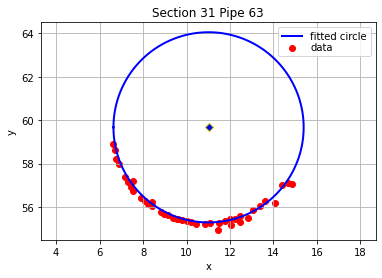

The fitted center point is: (11.013216,59.669029)
The as-designed center point is: (10.083039,59.69753)
The distance between them is: 0.9306135
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


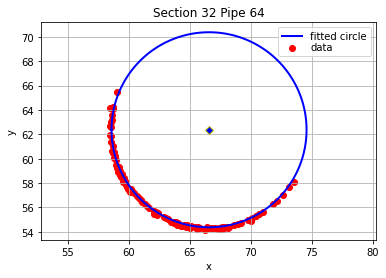

The fitted center point is: (66.570811,62.376541)
The as-designed center point is: (65.408948,63.692353)
The distance between them is: 1.7553595
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


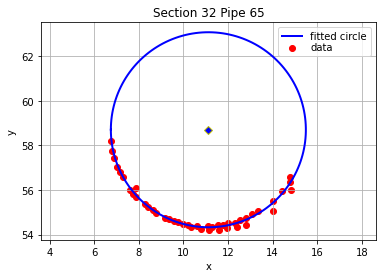

The fitted center point is: (11.119819,58.704856)
The as-designed center point is: (10.083196,58.967741)
The distance between them is: 1.0694371
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


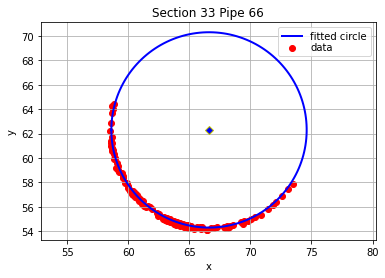

The fitted center point is: (66.60681,62.302229)
The as-designed center point is: (65.408949,63.687198)
The distance between them is: 1.8311226
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


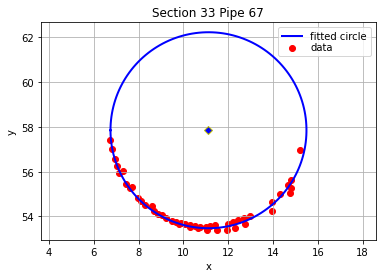

The fitted center point is: (11.115633,57.850604)
The as-designed center point is: (10.083322,58.362505)
The distance between them is: 1.1522624
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


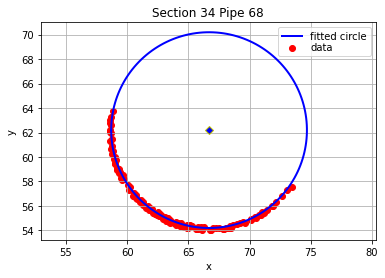

The fitted center point is: (66.693552,62.197612)
The as-designed center point is: (65.408948,63.69103)
The distance between them is: 1.9698997
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


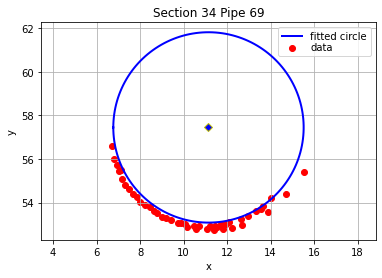

The fitted center point is: (11.145806,57.450973)
The as-designed center point is: (10.083418,57.894635)
The distance between them is: 1.1513054
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


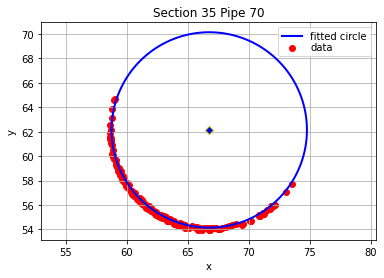

The fitted center point is: (66.766289,62.149302)
The as-designed center point is: (65.408949,63.689333)
The distance between them is: 2.0528194
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


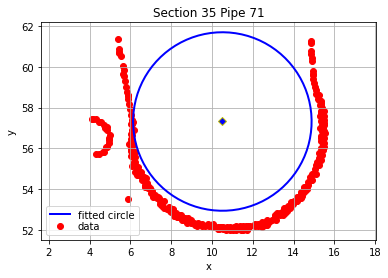

The fitted center point is: (10.511366,57.313965)
The as-designed center point is: (10.083487,57.562777)
The distance between them is: 0.4949625
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


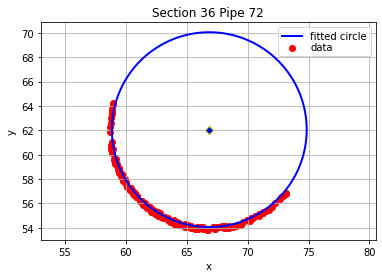

The fitted center point is: (66.850643,62.05494)
The as-designed center point is: (65.408948,63.689723)
The distance between them is: 2.1796789
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


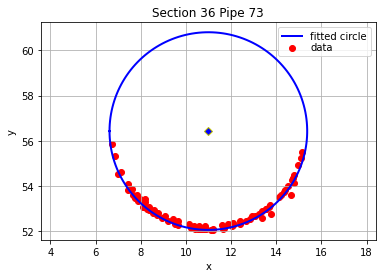

The fitted center point is: (10.995282,56.428894)
The as-designed center point is: (10.083533,57.360924)
The distance between them is: 1.3038275
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


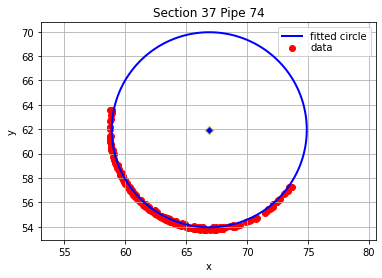

The fitted center point is: (66.887791,61.957376)
The as-designed center point is: (65.408948,63.689727)
The distance between them is: 2.2777218
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


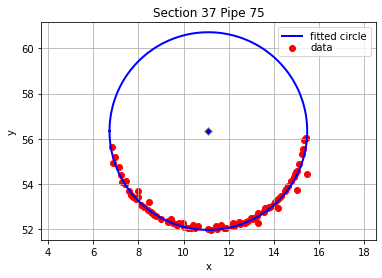

The fitted center point is: (11.096634,56.340776)
The as-designed center point is: (10.083555,57.297695)
The distance between them is: 1.3935649
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


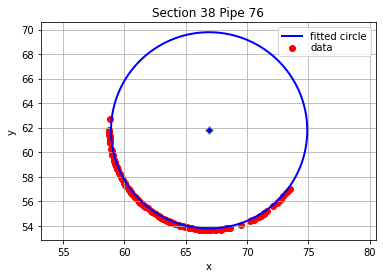

The fitted center point is: (66.90565,61.77701)
The as-designed center point is: (65.408948,63.690329)
The distance between them is: 2.4291781
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


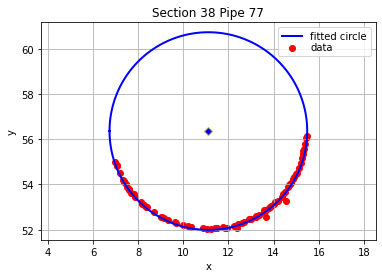

The fitted center point is: (11.108738,56.363534)
The as-designed center point is: (10.083534,57.382158)
The distance between them is: 1.4452121
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


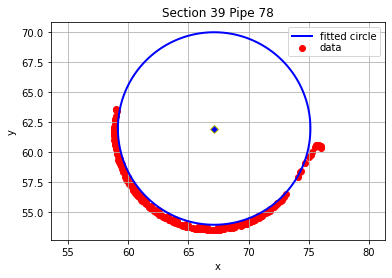

The fitted center point is: (67.141598,61.958201)
The as-designed center point is: (65.408949,63.689107)
The distance between them is: 2.4491035
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


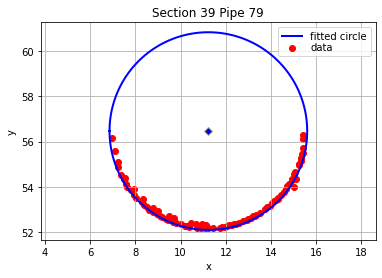

The fitted center point is: (11.227422,56.464396)
The as-designed center point is: (10.083534,57.421295)
The distance between them is: 1.4913536
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


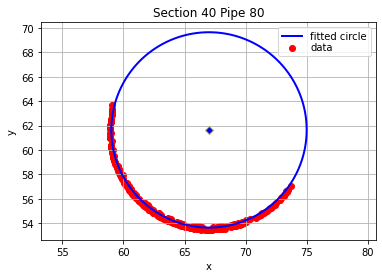

The fitted center point is: (67.004256,61.642661)
The as-designed center point is: (65.408948,63.689841)
The distance between them is: 2.5953716
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


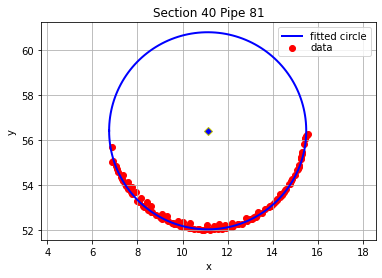

The fitted center point is: (11.11557,56.40027)
The as-designed center point is: (10.083565,57.317245)
The distance between them is: 1.3805352
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


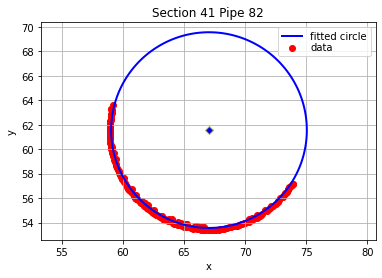

The fitted center point is: (67.041124,61.561278)
The as-designed center point is: (65.408949,63.689687)
The distance between them is: 2.6821857
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


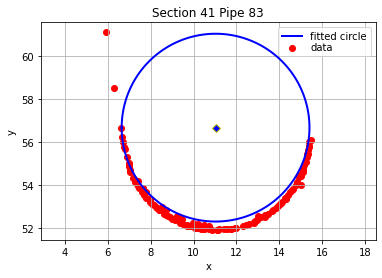

The fitted center point is: (11.026098,56.685118)
The as-designed center point is: (10.0836,57.146347)
The distance between them is: 1.049302
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


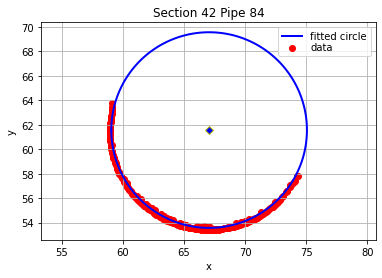

The fitted center point is: (67.062622,61.565646)
The as-designed center point is: (65.408948,63.689807)
The distance between them is: 2.6919691
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


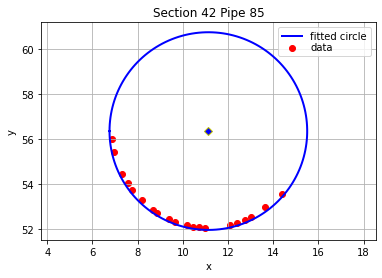

The fitted center point is: (11.131145,56.354638)
The as-designed center point is: (10.08362,57.019061)
The distance between them is: 1.2404703
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


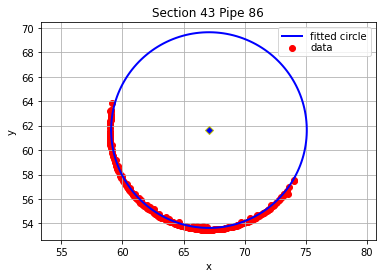

The fitted center point is: (67.076054,61.634159)
The as-designed center point is: (65.408948,63.689855)
The distance between them is: 2.6467203
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


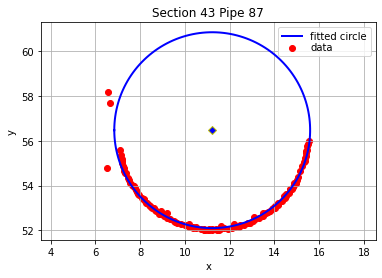

The fitted center point is: (11.218714,56.476296)
The as-designed center point is: (10.083636,56.951211)
The distance between them is: 1.2304253
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


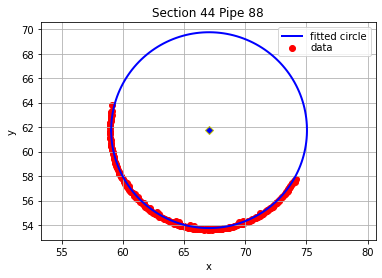

The fitted center point is: (67.053999,61.751284)
The as-designed center point is: (65.408948,63.688445)
The distance between them is: 2.5414141
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


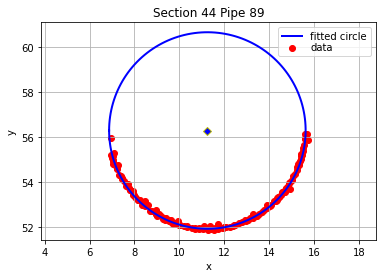

The fitted center point is: (11.247669,56.296409)
The as-designed center point is: (10.083653,56.917248)
The distance between them is: 1.3192325
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


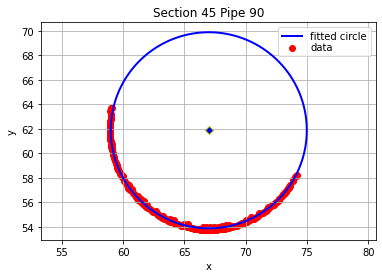

The fitted center point is: (66.986293,61.871874)
The as-designed center point is: (65.408947,63.692689)
The distance between them is: 2.4090221
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


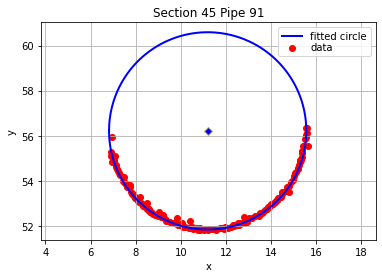

The fitted center point is: (11.194821,56.213252)
The as-designed center point is: (10.083663,56.92133)
The distance between them is: 1.3175912
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


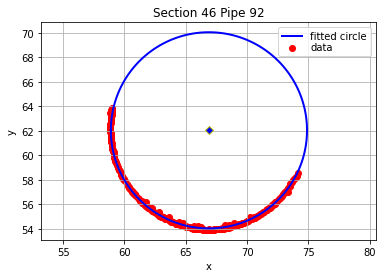

The fitted center point is: (66.893666,62.042531)
The as-designed center point is: (65.40895,63.6881)
The distance between them is: 2.2163662
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


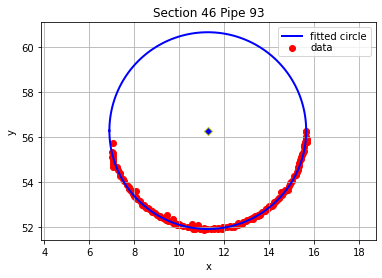

The fitted center point is: (11.264498,56.284728)
The as-designed center point is: (10.083667,56.974843)
The distance between them is: 1.3677063
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


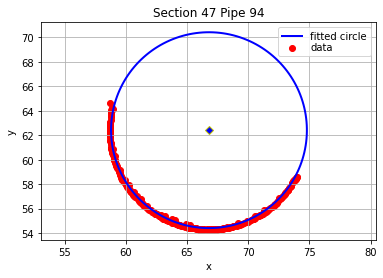

The fitted center point is: (66.799261,62.410388)
The as-designed center point is: (65.408945,63.690036)
The distance between them is: 1.8895707
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


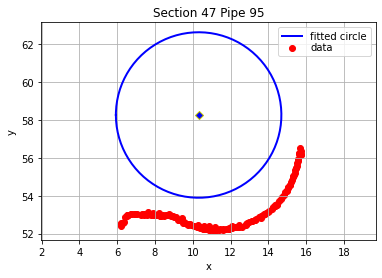

The fitted center point is: (10.30697,58.26577)
The as-designed center point is: (10.083647,57.131381)
The distance between them is: 1.1561624
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


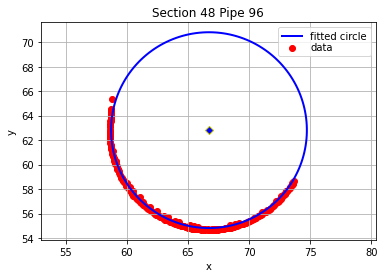

The fitted center point is: (66.719546,62.813078)
The as-designed center point is: (65.408953,63.68961)
The distance between them is: 1.5766935
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


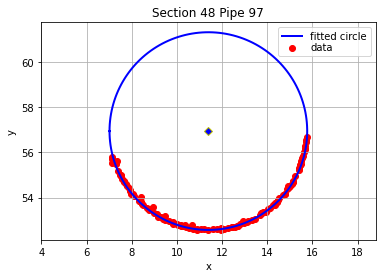

The fitted center point is: (11.392382,56.943521)
The as-designed center point is: (10.083599,57.402983)
The distance between them is: 1.3870899
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


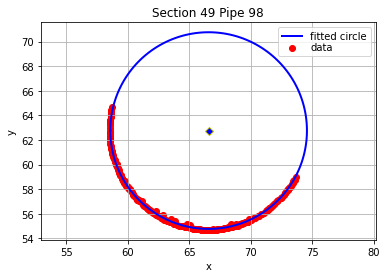

The fitted center point is: (66.580021,62.761048)
The as-designed center point is: (65.408947,63.689732)
The distance between them is: 1.4946131
The fitted radius is: 8 and the actual radius is: 8.0
The difference between them is: 0.0


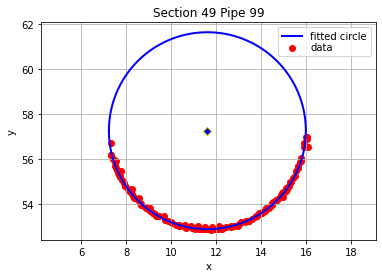

The fitted center point is: (11.598179,57.248724)
The as-designed center point is: (10.083495,57.793803)
The distance between them is: 1.609776
The fitted radius is: 4.375 and the actual radius is: 4.375
The difference between them is: 0.0


In [10]:
from circle_fit import least_squares_circle, plot_data_circle

sec_count = 0
for n in range(50): 
    a = PassesSecondNoiseTestBySection[2 * n:2 * n + 2]
    if len(a[0]) > 0:
        xc,yc,r = least_squares_circle(a[0], 8)
        plot_data_circle((list(zip(*a[0]))[0]),(list(zip(*a[0]))[1]),xc,yc,r)
        plt.title("Section " + str(sec_count) + " Pipe " + str(sec_count*2))
        plt.show()
        printInfo(r, xc, yc, sec_count, 0)
    else:
        pass
    if len(a[1]) > 0:
        xc,yc,r = least_squares_circle(a[1], 4.375)
        plot_data_circle((list(zip(*a[1]))[0]),(list(zip(*a[1]))[1]),xc,yc,r)
        plt.title("Section " + str(sec_count) + " Pipe " + str(sec_count*2 + 1))
        plt.show()
        printInfo(r, xc, yc, sec_count, 1)
    else:
        pass
    sec_count += 1